# Introduction

In [1]:
!pip install transformers

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

2025-05-08 12:11:26.290098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746706286.502267      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746706286.559265      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploratory Data Analysis

In [3]:
cpt=0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        cpt+=1
        print(os.path.join(dirname, filename))
        if cpt >5:
            break

/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/test_sent_emo.csv
/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/README.txt
/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/._train_splits
/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/dev_sent_emo.csv
/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/test/._output_repeated_splits_test
/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/test/output_repeated_splits_test/dia194_utt3.mp4
/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/train/train_sent_emo.csv
/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/train/train_splits/dia557_utt0.mp4
/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/dev/dev_splits_complete/dia40_utt10.mp4
/kaggle/input/meld-dataset/MELD-Features-Models/MELD.Features.Models/README.txt
/kaggle/input/meld-dataset/MELD-Features-Models/MELD.Features.Models/features/text_glove_CNN_emotion.pkl
/kaggle/input/meld-dataset/MELD-Features-Models/MELD.Features.Models/models/bimodal_weights_emotion.hdf5


In [4]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nCol = df.shape[1]
    nGraphRow = int(math.ceil(nGraphShown / float(nGraphPerRow)))  # Ensure it's an int

    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')

    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]

        if not np.issubdtype(columnDf.dtype, np.number):
            valueCounts = columnDf.value_counts()
            valueCounts.plot(kind='bar')
        else:
            columnDf.hist()
        
        plt.ylabel('counts')
        plt.title(f'{columnDf.name} (column {i})')

    plt.tight_layout()
    plt.show()

In [5]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna(axis='columns')  # Drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]]  # Keep columns with more than one unique value

    if df.shape[1] < 2:
        print("Not enough columns for correlation matrix.")
        return

    corr = df.corr(numeric_only=True)

    plt.figure(figsize=(graphWidth, graphWidth))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix')
    plt.show()

In [6]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include=[np.number])  # Keep only numerical columns
    df = df.dropna(axis='columns')  # Drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]]  # Keep columns with >1 unique value

    if df.shape[1] > 10:
        print("Too many numerical columns for scatter matrix, reducing to first 10.")
        df = df.iloc[:, :10]

    scatter_matrix(df, alpha=0.75, figsize=(plotSize, plotSize), diagonal='hist')

    plt.suptitle('Scatter Matrix', fontsize=textSize)
    plt.show()

**1st file: dev_sent_emo.csv**

In [7]:
nRowsRead = 50 # specify 'None' if want to read whole file
# dev_sent_emo.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('../input/meld-dataset/MELD-RAW/MELD.Raw/dev_sent_emo.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'dev_sent_emo.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 50 rows and 11 columns


In [8]:
df1.head(5)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049"
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261"
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915"
3,4,Youre a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960"
4,5,"Aww, man, now we wont be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505"


**Distribution graphs**

/tmp/ipykernel_19/2772724231.py:21: UserWarning: Glyph 146 (\x92) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/2772724231.py:21: UserWarning: Glyph 133 (\x85) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/2772724231.py:21: UserWarning: Glyph 151 (\x97) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


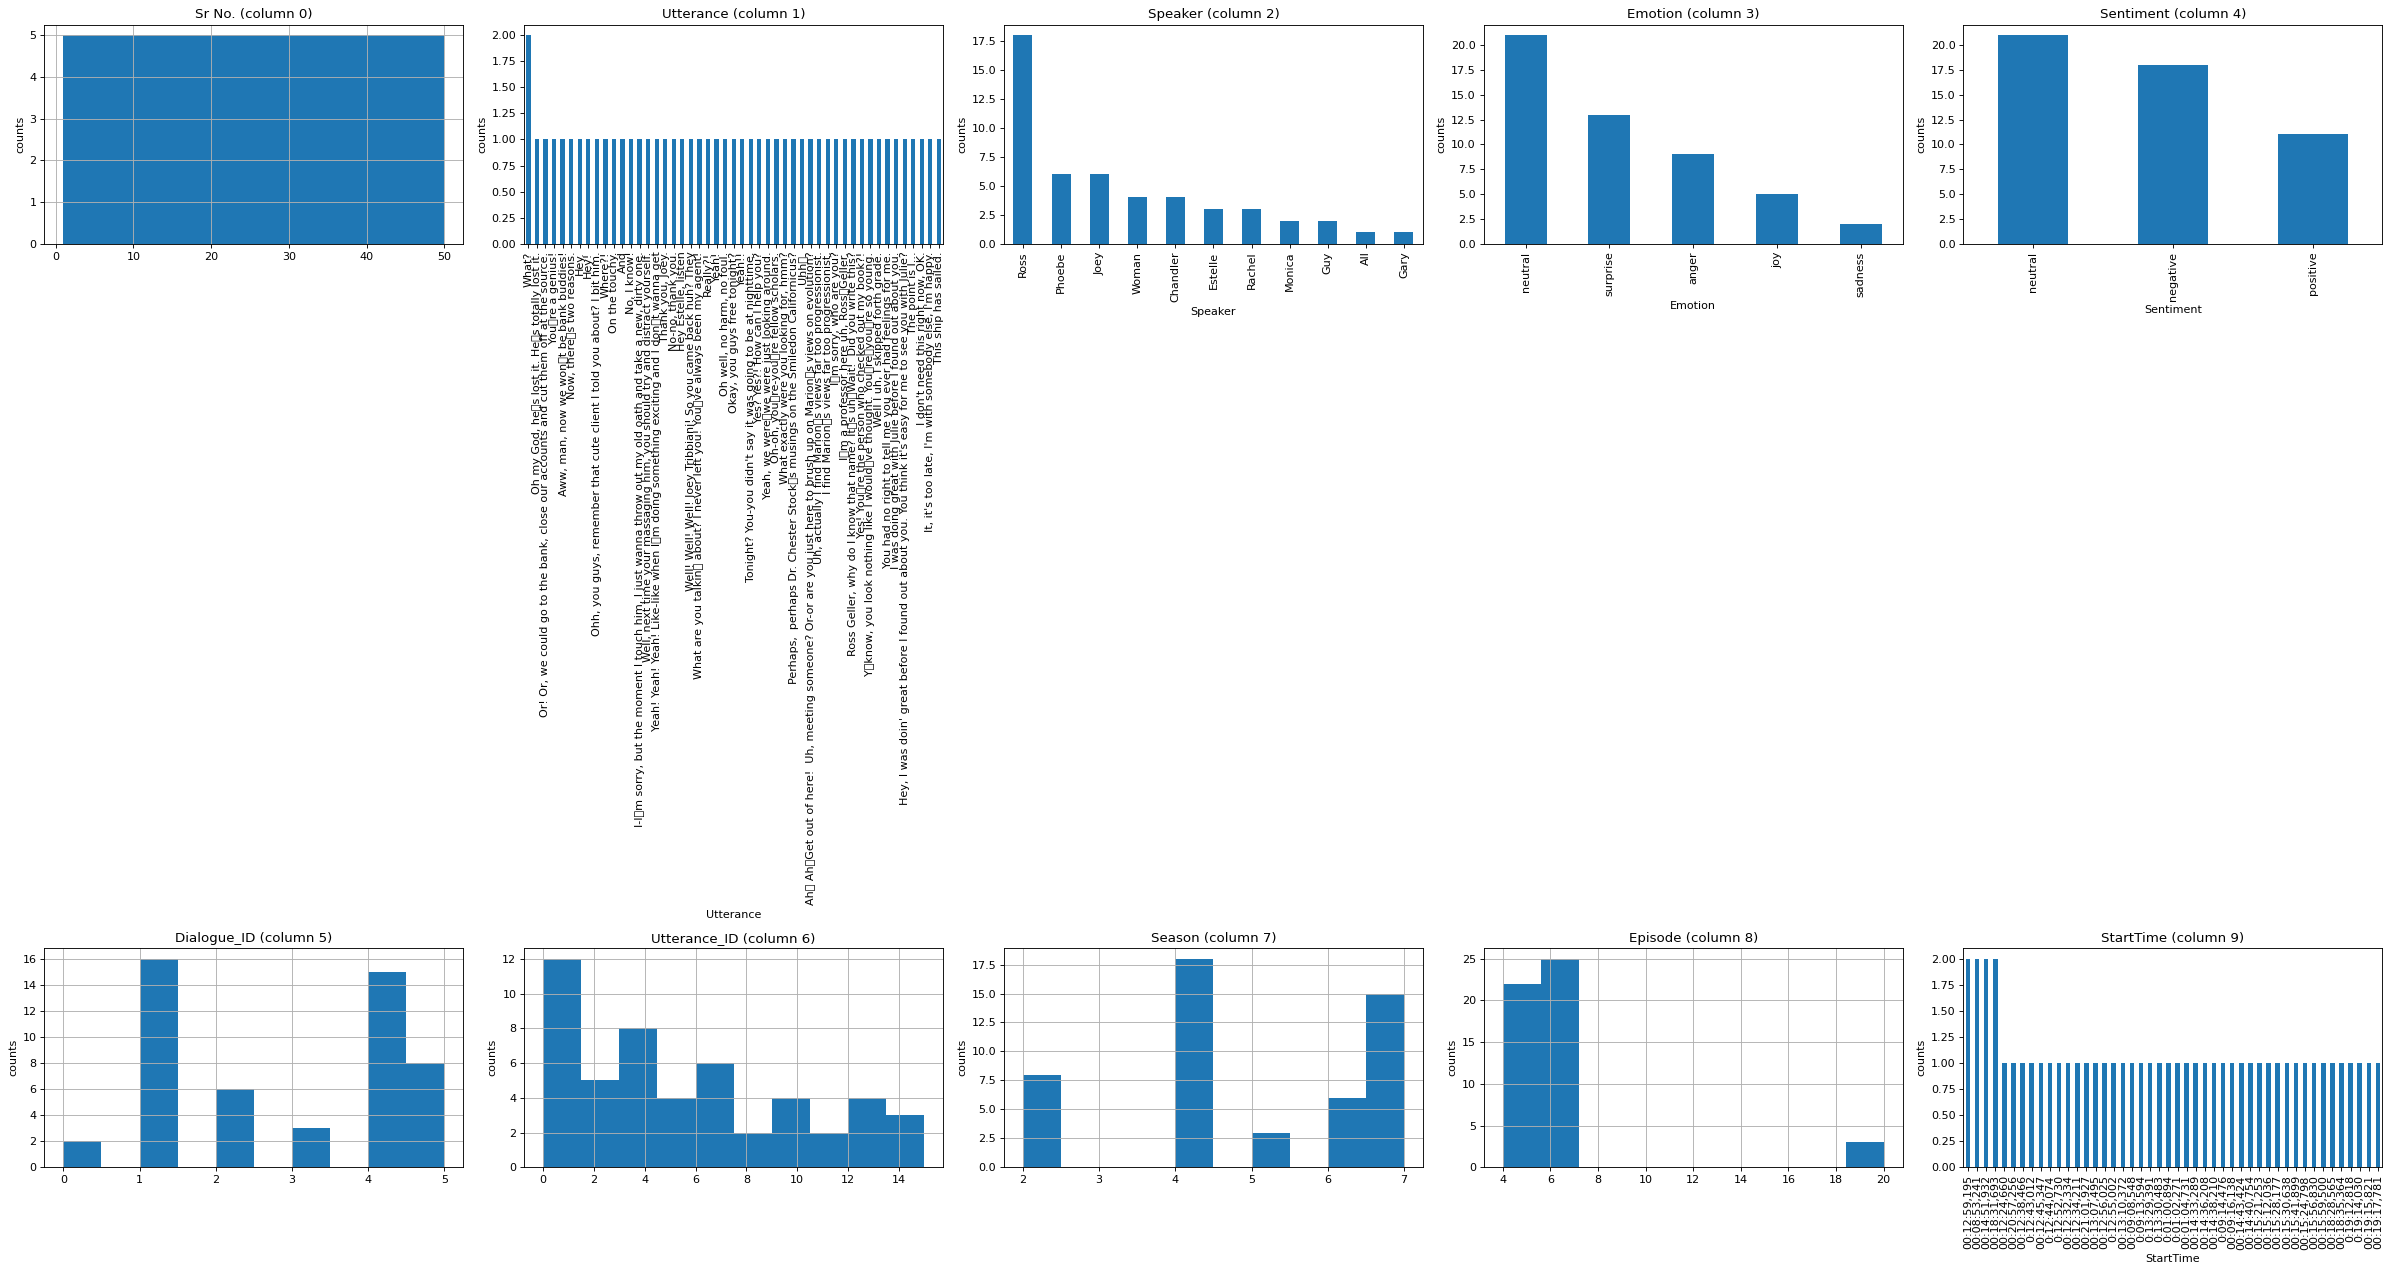

In [9]:
plotPerColumnDistribution(df1, 10, 5)

**Correlation matrix**

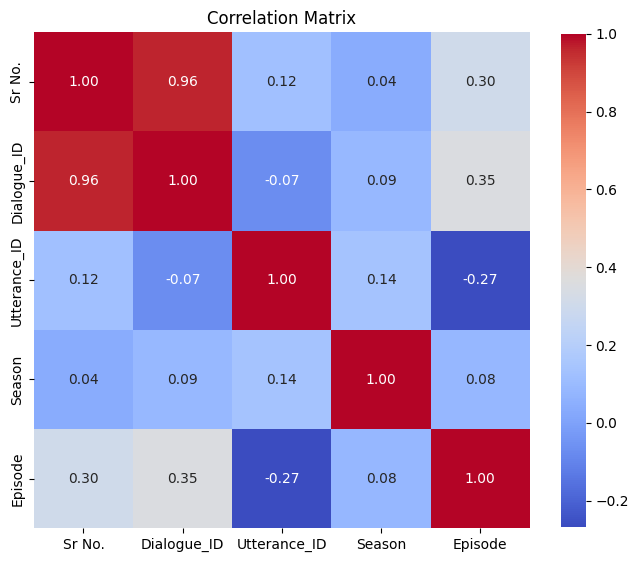

In [10]:
plotCorrelationMatrix(df1, 8)

**Scatter and density plots**

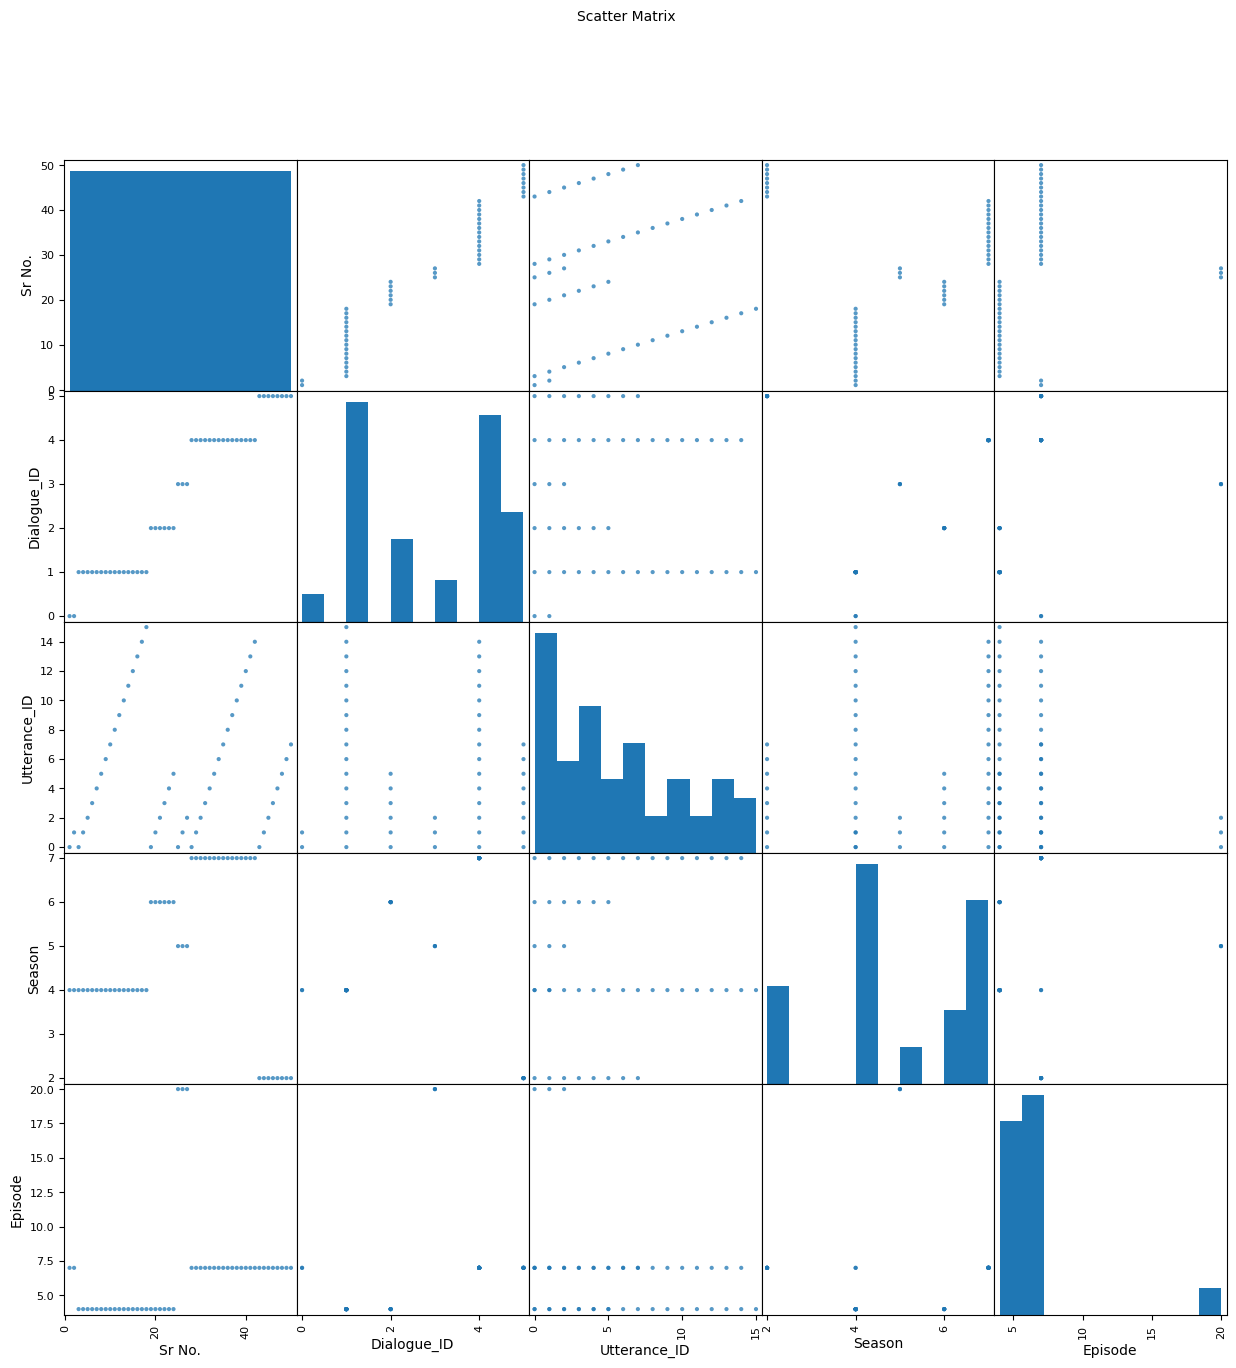

In [11]:
plotScatterMatrix(df1, 15, 10)

**2nd file: test_sent_emo.csv**

In [12]:
nRowsRead = 50 # specify 'None' if want to read whole file
# test_sent_emo.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv('../input/meld-dataset/MELD-RAW/MELD.Raw/test_sent_emo.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'test_sent_emo.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 50 rows and 11 columns


In [13]:
df2.head(5)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378"
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385"
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520"
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146"
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833"


**Distribution graphs**

/tmp/ipykernel_19/2772724231.py:21: UserWarning: Glyph 146 (\x92) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/2772724231.py:21: UserWarning: Glyph 151 (\x97) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/2772724231.py:21: UserWarning: Glyph 145 (\x91) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 145 (\x91) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


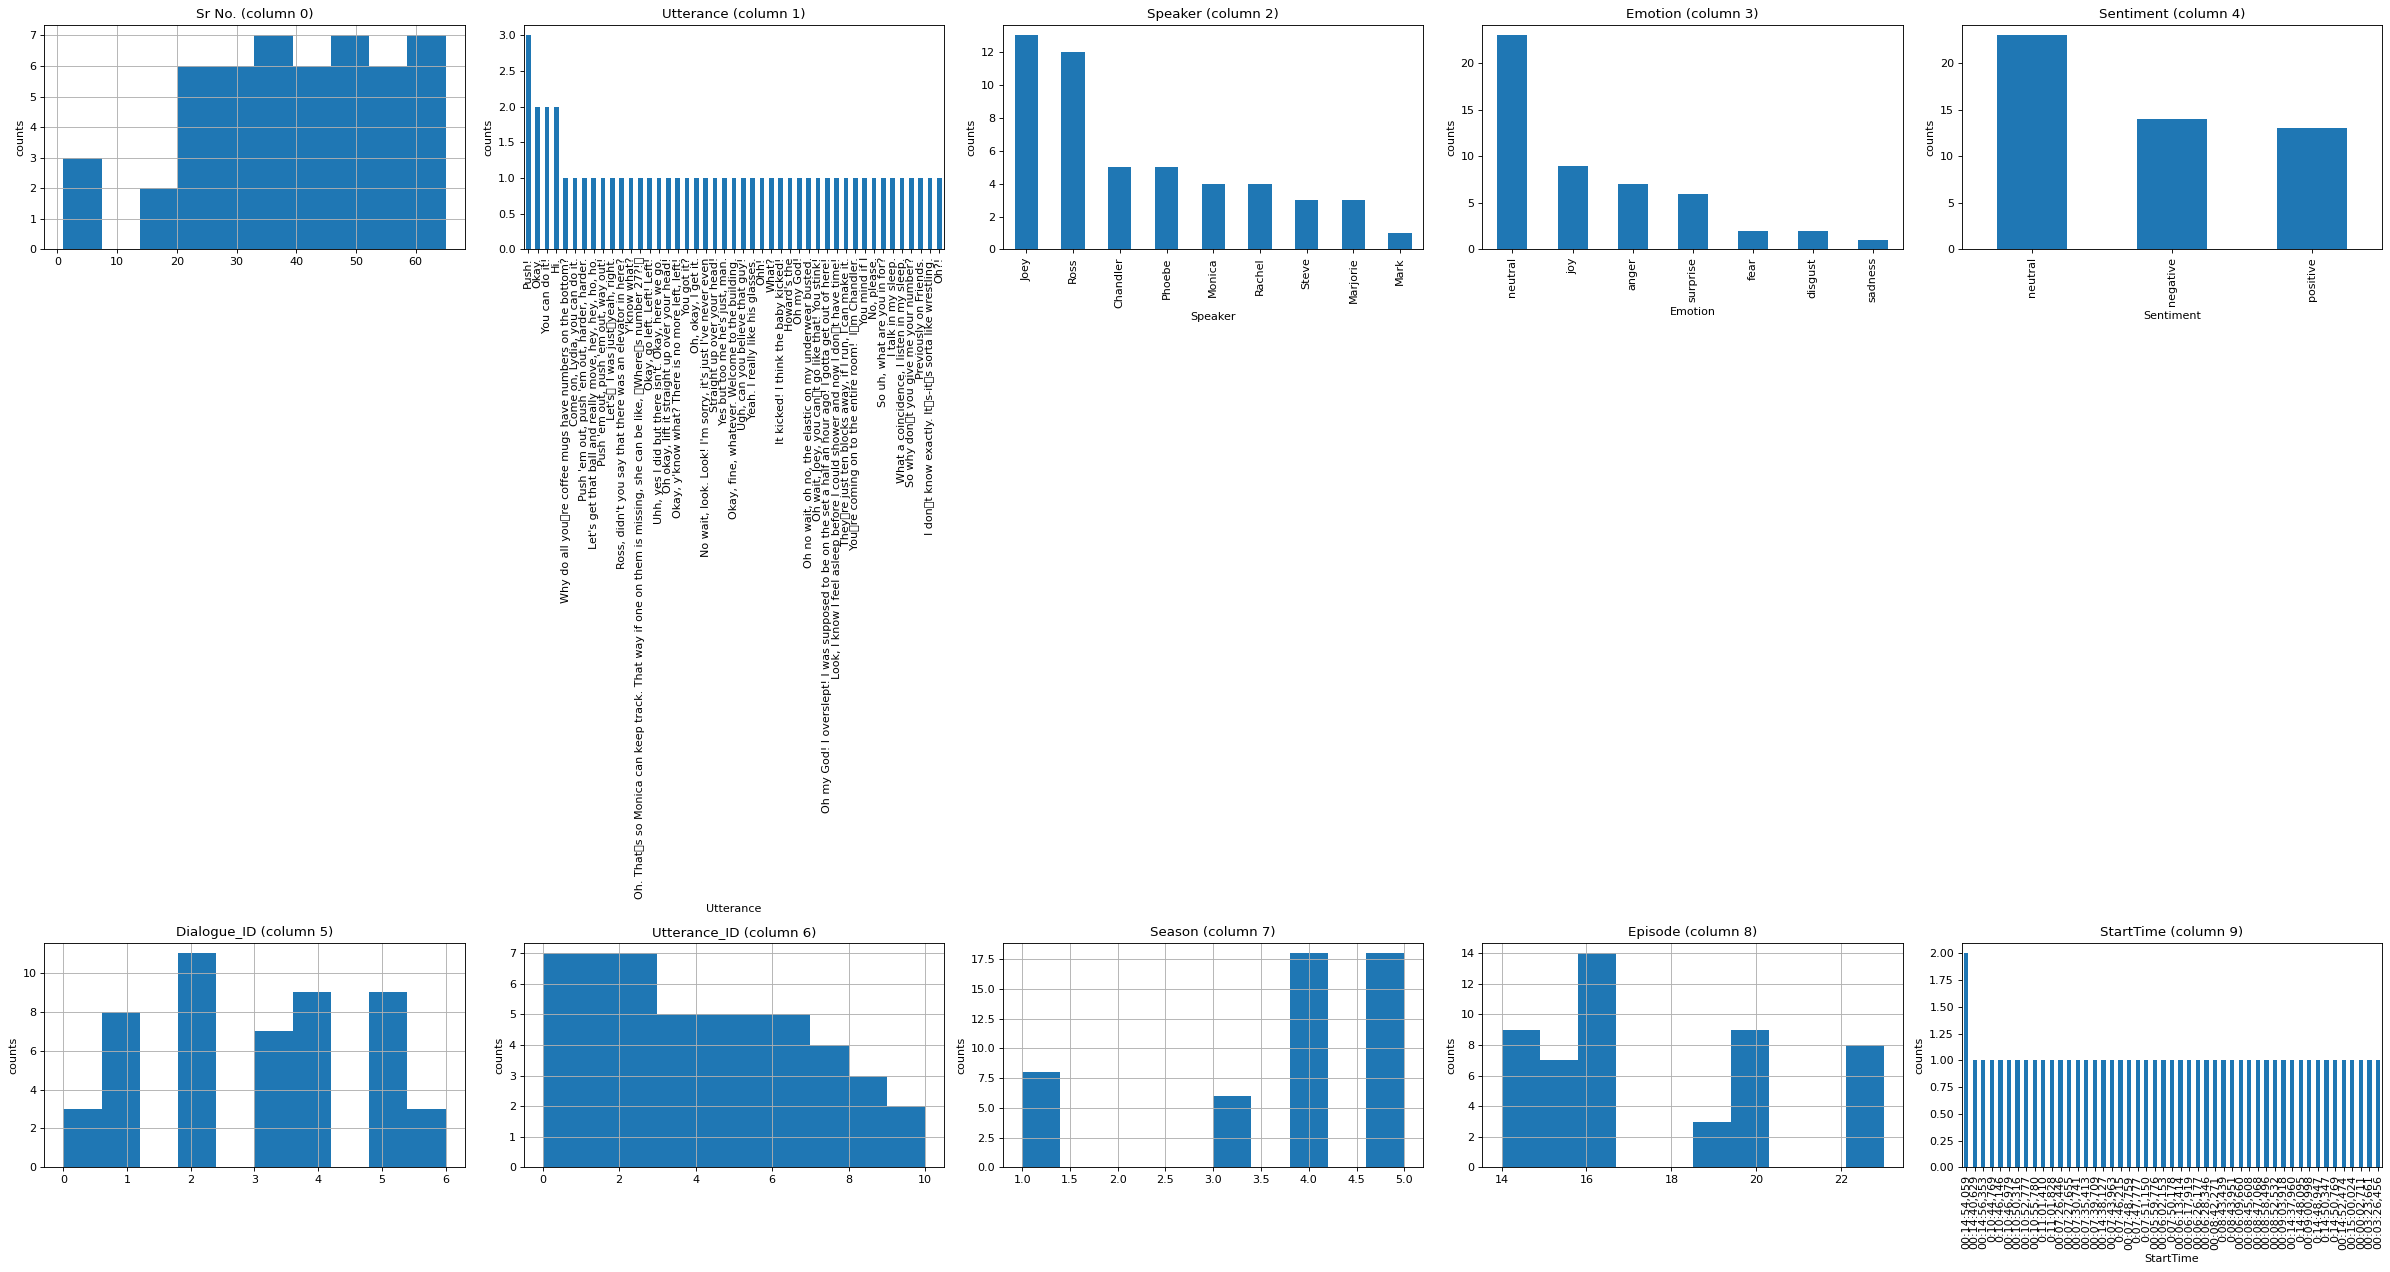

In [14]:
plotPerColumnDistribution(df2, 10, 5)

**Correlation matrix**

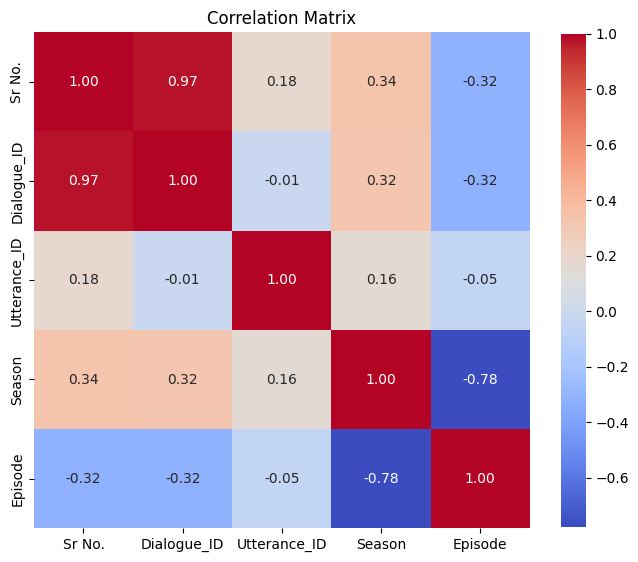

In [15]:
plotCorrelationMatrix(df2, 8)

**Scatter and density plots**

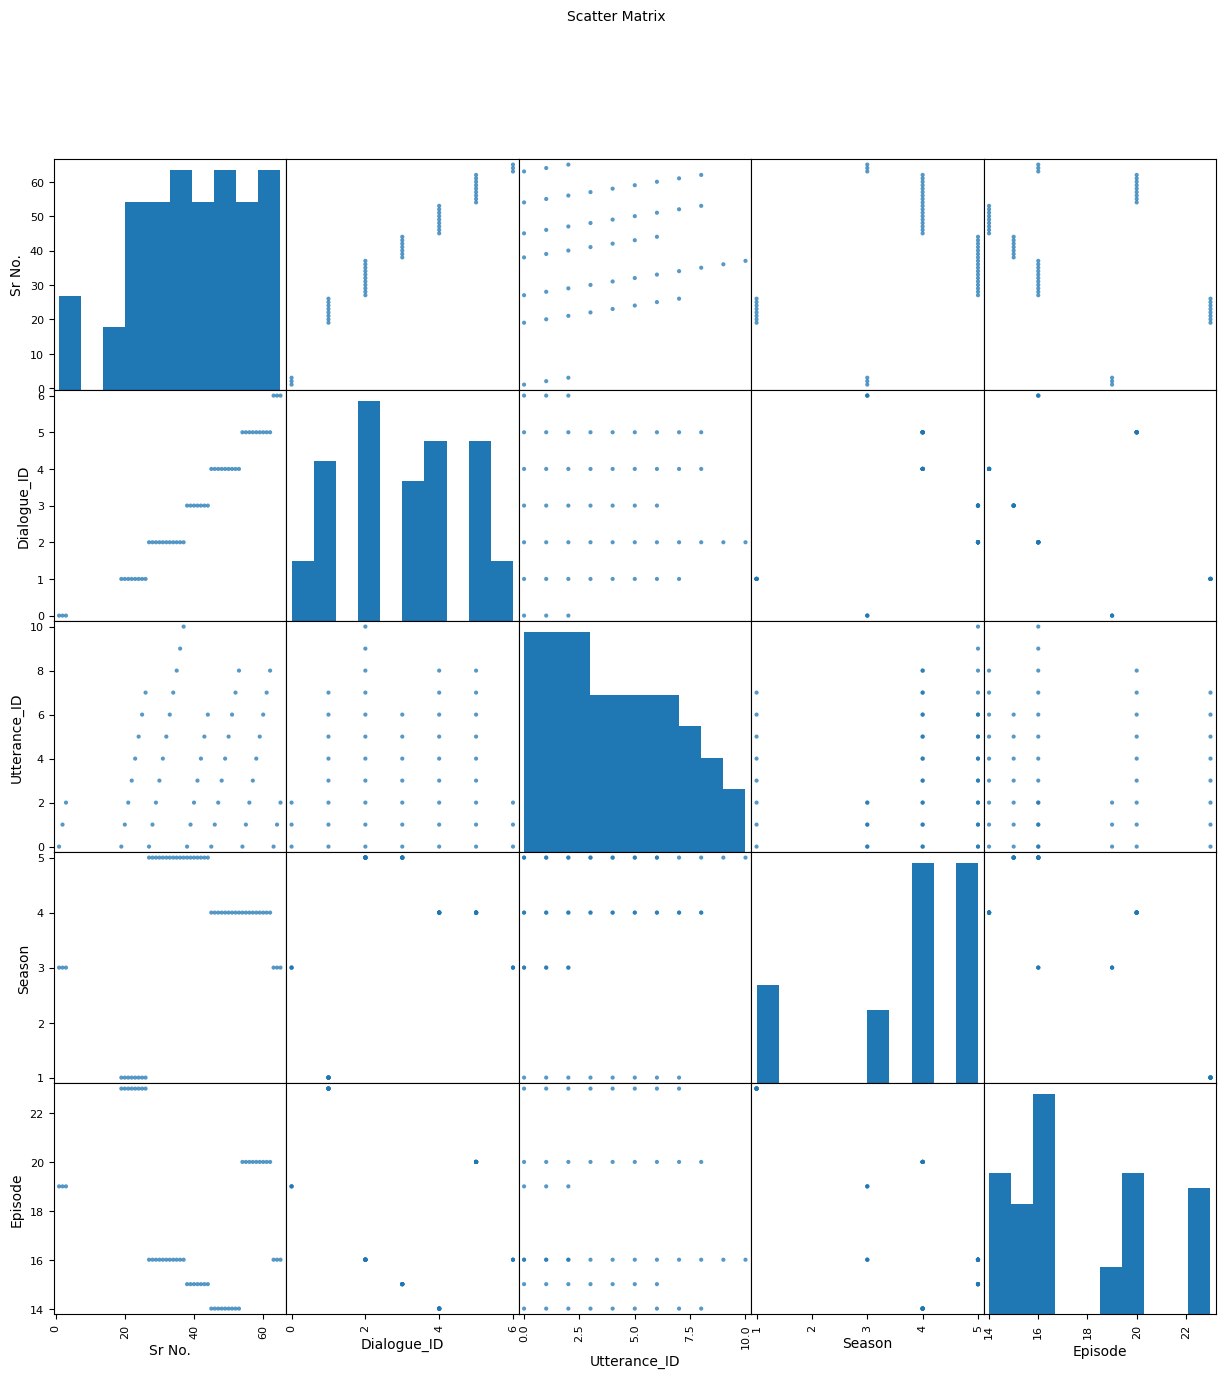

In [16]:
plotScatterMatrix(df2, 15, 10)

**3rd file: train_sent_emo.csv**

In [17]:
nRowsRead = 50 # specify 'None' if want to read whole file
# train_sent_emo.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df3 = pd.read_csv('../input/meld-dataset/MELD-RAW/MELD.Raw/train/train_sent_emo.csv', delimiter=',', nrows = nRowsRead)
df3.dataframeName = 'train_sent_emo.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 50 rows and 11 columns


In [18]:
df3.head(5)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


**Distribution graphs**

/tmp/ipykernel_19/2772724231.py:21: UserWarning: Glyph 146 (\x92) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


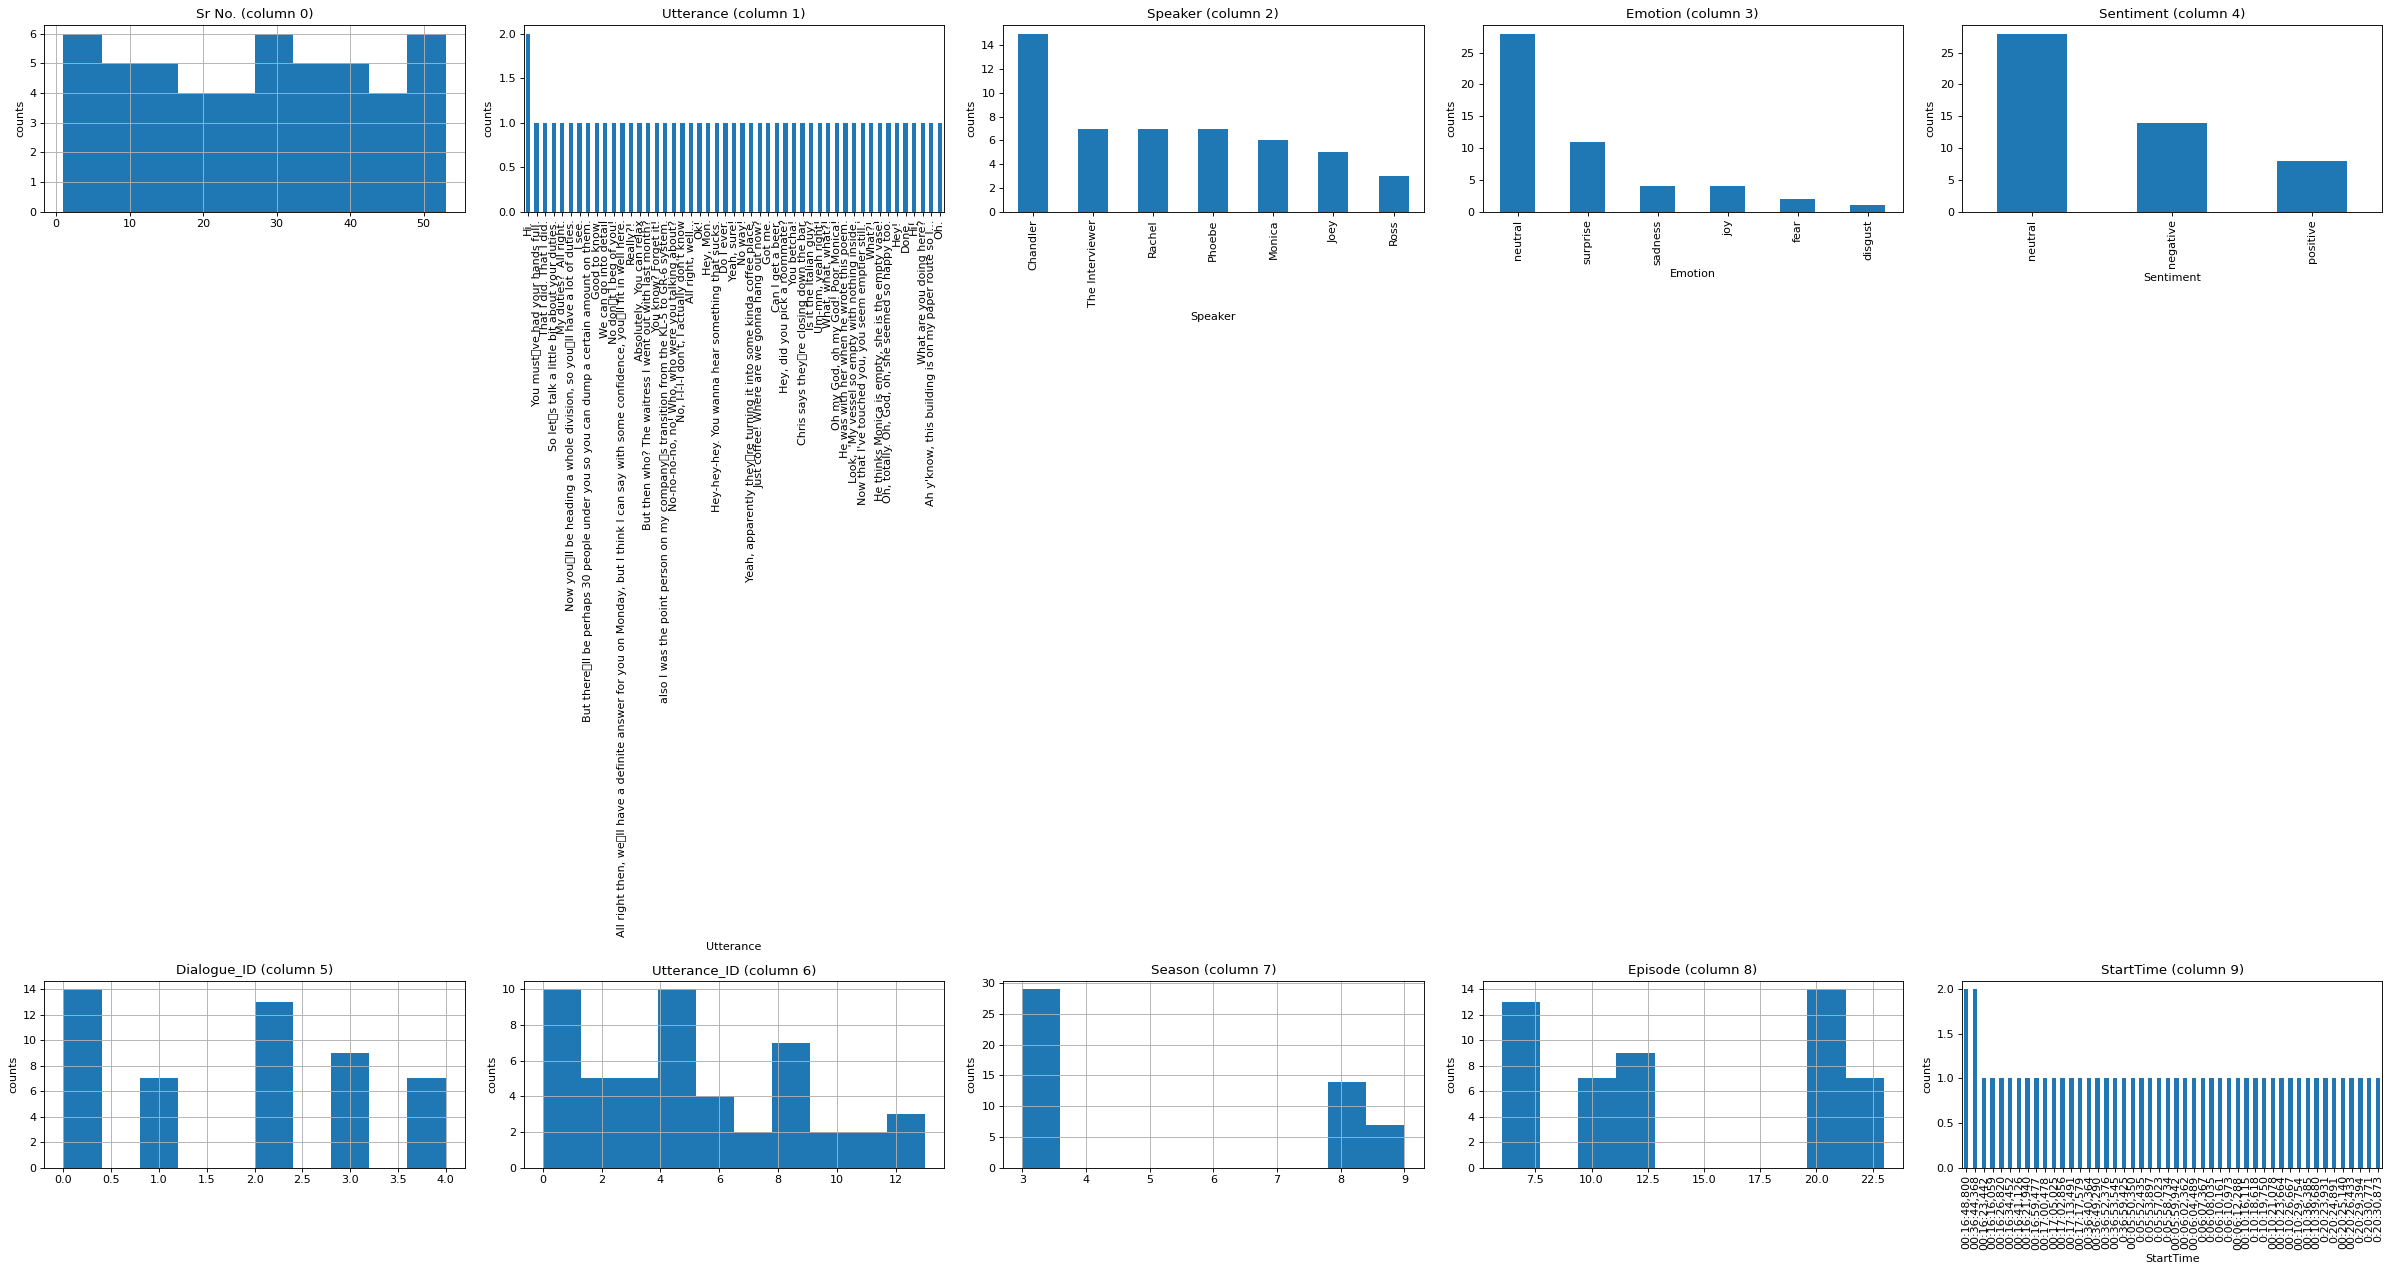

In [19]:
plotPerColumnDistribution(df3, 10, 5)

**Correlation matrix**

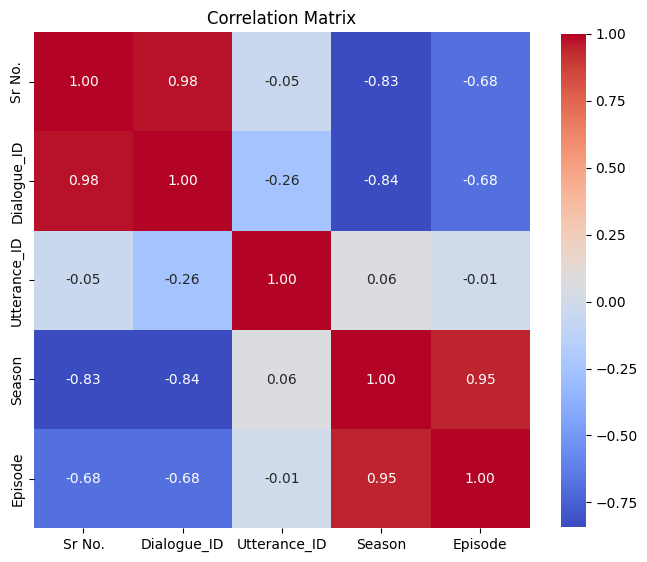

In [20]:
plotCorrelationMatrix(df3, 8)

**Scatter and density plots**

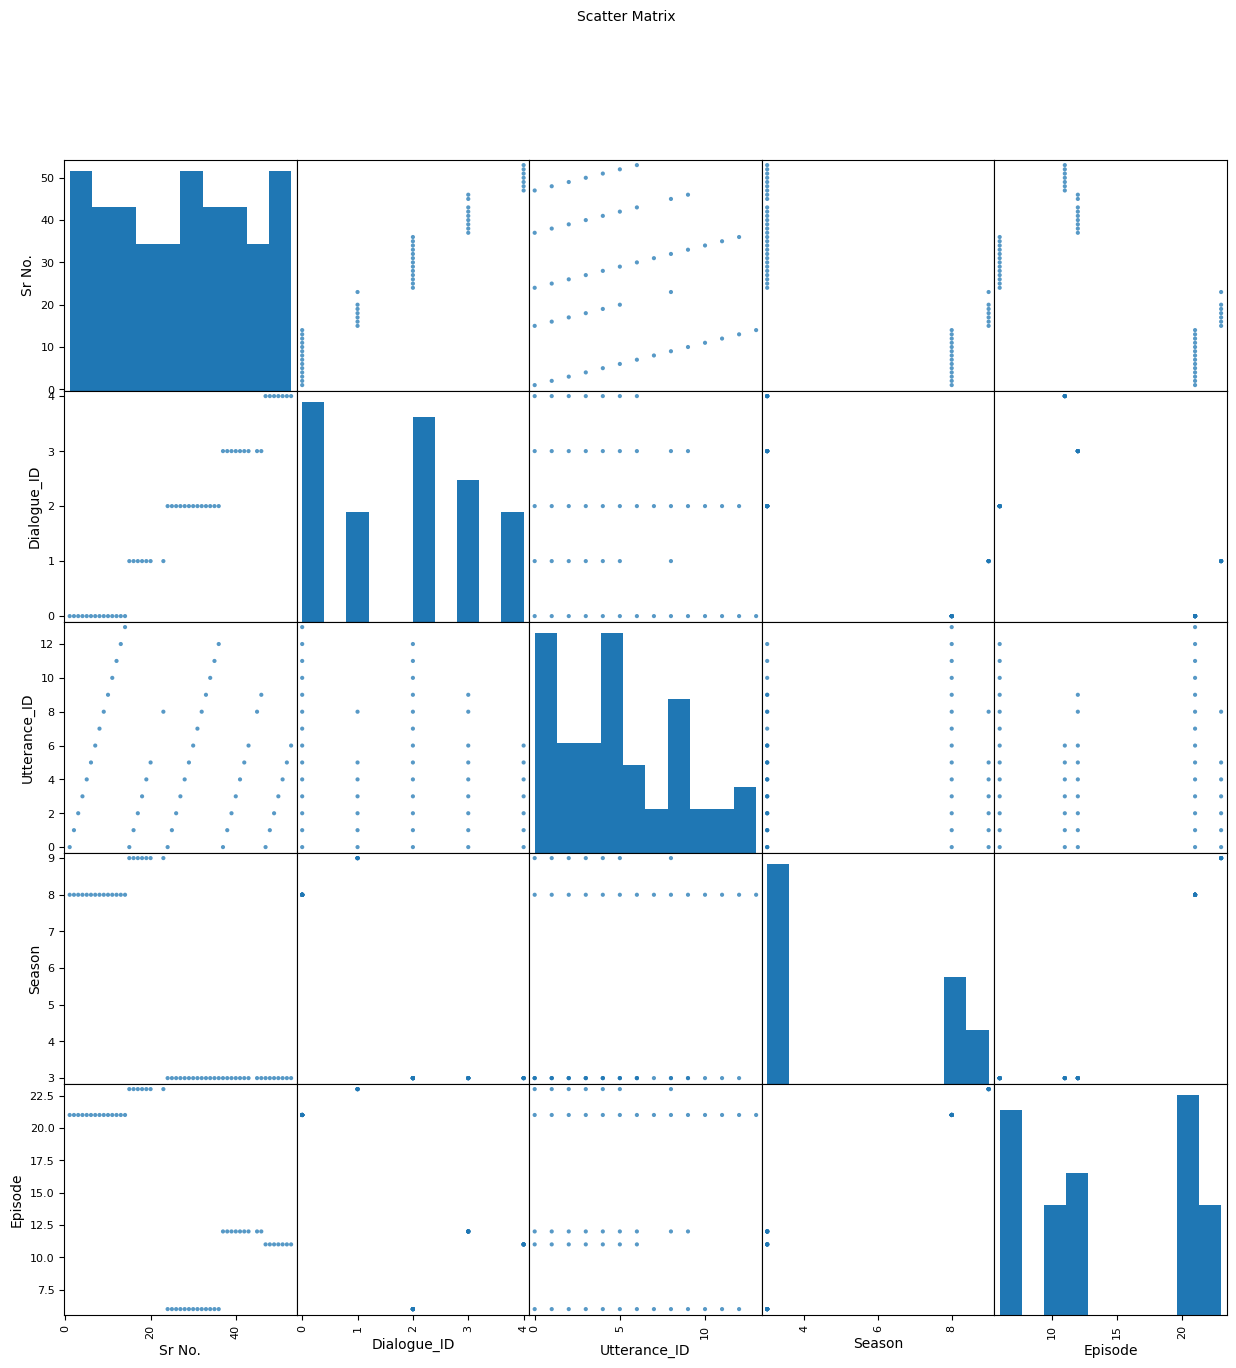

In [21]:
plotScatterMatrix(df3, 15, 10)

## Implementation of Multimodal EmotionLines Dataset (MELD)

In [22]:
!git clone https://github.com/declare-lab/MELD.git

Cloning into 'MELD'...
remote: Enumerating objects: 493, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 493 (delta 10), reused 12 (delta 5), pack-reused 475 (from 1)
Receiving objects: 100% (493/493), 8.12 MiB | 41.16 MiB/s, done.
Resolving deltas: 100% (258/258), done.


# Training

## Loading MELD Dataset

In [23]:
train_df = pd.read_csv('/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/train/train_sent_emo.csv')
val_df = pd.read_csv('/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/dev_sent_emo.csv')
test_df = pd.read_csv('/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/test_sent_emo.csv')

In [24]:
# Filter out rows with missing emotion labels
train_df = train_df.dropna(subset=['Emotion'])
val_df = val_df.dropna(subset=['Emotion'])
test_df = test_df.dropna(subset=['Emotion'])

## Encode Emotion Labels

In [25]:
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['Emotion'])
val_df['label'] = le.transform(val_df['Emotion'])
test_df['label'] = le.transform(test_df['Emotion'])

In [26]:
label_map = dict(zip(le.classes_, le.transform(le.classes_)))

## Tokenization

In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [28]:
def tokenize(texts, labels, max_len=128):
    encodings = tokenizer(list(texts), padding=True, truncation=True, max_length=max_len)
    return encodings, labels

## PyTorch Dataset Class

In [29]:
class MELDDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

## Prepare DataLoaders

In [30]:
train_enc, train_labels = tokenize(train_df['Utterance'], train_df['label'])
val_enc, val_labels = tokenize(val_df['Utterance'], val_df['label'])
test_enc, test_labels = tokenize(test_df['Utterance'], test_df['label'])

In [31]:
train_dataset = MELDDataset(train_enc, train_labels)
val_dataset = MELDDataset(val_enc, val_labels)
test_dataset = MELDDataset(test_enc, test_labels)

In [32]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

## Define Model

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [34]:
optimizer = AdamW(model.parameters(), lr=2e-5)

## Training Loop

In [35]:
train_losses = []
val_accuracies = []

In [36]:
def train(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy

In [37]:
def evaluate(model, loader):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, preds)
    report = classification_report(true_labels, preds, target_names=le.classes_, output_dict=False)
    return report, accuracy

## Run Training

In [38]:
epochs = 100
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, train_loader)
    train_losses.append(train_loss)

    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.4f}")

    report, val_acc = evaluate(model, val_loader)
    val_accuracies.append(val_acc)

    print(f"Validation Accuracy: {val_acc:.4f}")
    print("Validation Report:\n", report)


Epoch 1/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 1.2051 | Training Accuracy: 0.5957


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.6195
Validation Report:
               precision    recall  f1-score   support

       anger       0.46      0.38      0.41       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.54      0.63      0.59       163
     neutral       0.69      0.86      0.76       470
     sadness       0.62      0.21      0.31       111
    surprise       0.59      0.65      0.62       150

    accuracy                           0.62      1109
   macro avg       0.41      0.39      0.38      1109
weighted avg       0.58      0.62      0.58      1109


Epoch 2/100


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.9715 | Training Accuracy: 0.6828


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.6186
Validation Report:
               precision    recall  f1-score   support

       anger       0.47      0.41      0.44       153
     disgust       0.50      0.05      0.08        22
        fear       0.00      0.00      0.00        40
         joy       0.63      0.47      0.54       163
     neutral       0.67      0.90      0.77       470
     sadness       0.57      0.23      0.32       111
    surprise       0.56      0.67      0.61       150

    accuracy                           0.62      1109
   macro avg       0.49      0.39      0.39      1109
weighted avg       0.58      0.62      0.58      1109


Epoch 3/100


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.7297 | Training Accuracy: 0.7650


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5942
Validation Report:
               precision    recall  f1-score   support

       anger       0.42      0.50      0.46       153
     disgust       0.56      0.23      0.32        22
        fear       0.29      0.12      0.18        40
         joy       0.49      0.58      0.53       163
     neutral       0.74      0.76      0.75       470
     sadness       0.55      0.28      0.37       111
    surprise       0.51      0.60      0.55       150

    accuracy                           0.59      1109
   macro avg       0.51      0.44      0.45      1109
weighted avg       0.59      0.59      0.58      1109


Epoch 4/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.5089 | Training Accuracy: 0.8414


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5996
Validation Report:
               precision    recall  f1-score   support

       anger       0.45      0.44      0.45       153
     disgust       0.36      0.23      0.28        22
        fear       0.62      0.20      0.30        40
         joy       0.52      0.51      0.52       163
     neutral       0.70      0.81      0.75       470
     sadness       0.50      0.27      0.35       111
    surprise       0.53      0.61      0.57       150

    accuracy                           0.60      1109
   macro avg       0.53      0.44      0.46      1109
weighted avg       0.59      0.60      0.58      1109


Epoch 5/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.3458 | Training Accuracy: 0.8942


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5753
Validation Report:
               precision    recall  f1-score   support

       anger       0.45      0.33      0.38       153
     disgust       0.67      0.27      0.39        22
        fear       0.60      0.15      0.24        40
         joy       0.41      0.64      0.50       163
     neutral       0.73      0.74      0.73       470
     sadness       0.49      0.27      0.35       111
    surprise       0.51      0.61      0.55       150

    accuracy                           0.58      1109
   macro avg       0.55      0.43      0.45      1109
weighted avg       0.58      0.58      0.56      1109


Epoch 6/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.2583 | Training Accuracy: 0.9196


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5825
Validation Report:
               precision    recall  f1-score   support

       anger       0.46      0.34      0.39       153
     disgust       0.46      0.27      0.34        22
        fear       0.30      0.17      0.22        40
         joy       0.44      0.48      0.46       163
     neutral       0.69      0.84      0.75       470
     sadness       0.44      0.26      0.33       111
    surprise       0.56      0.53      0.55       150

    accuracy                           0.58      1109
   macro avg       0.48      0.41      0.43      1109
weighted avg       0.56      0.58      0.56      1109


Epoch 7/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.2092 | Training Accuracy: 0.9340


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5852
Validation Report:
               precision    recall  f1-score   support

       anger       0.40      0.52      0.45       153
     disgust       0.35      0.27      0.31        22
        fear       0.31      0.12      0.18        40
         joy       0.53      0.48      0.51       163
     neutral       0.69      0.81      0.75       470
     sadness       0.44      0.18      0.26       111
    surprise       0.58      0.51      0.55       150

    accuracy                           0.59      1109
   macro avg       0.47      0.42      0.43      1109
weighted avg       0.57      0.59      0.57      1109


Epoch 8/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1688 | Training Accuracy: 0.9466


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5960
Validation Report:
               precision    recall  f1-score   support

       anger       0.46      0.37      0.41       153
     disgust       0.35      0.27      0.31        22
        fear       0.33      0.12      0.18        40
         joy       0.52      0.48      0.50       163
     neutral       0.68      0.84      0.75       470
     sadness       0.48      0.26      0.34       111
    surprise       0.56      0.59      0.58       150

    accuracy                           0.60      1109
   macro avg       0.48      0.42      0.44      1109
weighted avg       0.57      0.60      0.57      1109


Epoch 9/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1573 | Training Accuracy: 0.9486


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5816
Validation Report:
               precision    recall  f1-score   support

       anger       0.47      0.35      0.40       153
     disgust       0.44      0.32      0.37        22
        fear       0.36      0.20      0.26        40
         joy       0.52      0.45      0.48       163
     neutral       0.68      0.84      0.75       470
     sadness       0.44      0.22      0.29       111
    surprise       0.46      0.56      0.51       150

    accuracy                           0.58      1109
   macro avg       0.48      0.42      0.44      1109
weighted avg       0.56      0.58      0.56      1109


Epoch 10/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1500 | Training Accuracy: 0.9511


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5780
Validation Report:
               precision    recall  f1-score   support

       anger       0.49      0.31      0.38       153
     disgust       0.35      0.32      0.33        22
        fear       0.42      0.12      0.19        40
         joy       0.47      0.58      0.52       163
     neutral       0.68      0.80      0.73       470
     sadness       0.42      0.24      0.31       111
    surprise       0.54      0.57      0.55       150

    accuracy                           0.58      1109
   macro avg       0.48      0.42      0.43      1109
weighted avg       0.56      0.58      0.56      1109


Epoch 11/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1422 | Training Accuracy: 0.9529


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5636
Validation Report:
               precision    recall  f1-score   support

       anger       0.38      0.33      0.35       153
     disgust       0.60      0.27      0.37        22
        fear       0.44      0.20      0.28        40
         joy       0.51      0.51      0.51       163
     neutral       0.71      0.73      0.72       470
     sadness       0.34      0.41      0.37       111
    surprise       0.53      0.59      0.56       150

    accuracy                           0.56      1109
   macro avg       0.50      0.43      0.45      1109
weighted avg       0.56      0.56      0.56      1109


Epoch 12/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1321 | Training Accuracy: 0.9569


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5834
Validation Report:
               precision    recall  f1-score   support

       anger       0.49      0.37      0.42       153
     disgust       0.37      0.32      0.34        22
        fear       0.23      0.15      0.18        40
         joy       0.49      0.50      0.50       163
     neutral       0.68      0.83      0.75       470
     sadness       0.37      0.25      0.30       111
    surprise       0.58      0.51      0.54       150

    accuracy                           0.58      1109
   macro avg       0.46      0.42      0.43      1109
weighted avg       0.56      0.58      0.57      1109


Epoch 13/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1339 | Training Accuracy: 0.9537


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5582
Validation Report:
               precision    recall  f1-score   support

       anger       0.41      0.46      0.43       153
     disgust       0.46      0.27      0.34        22
        fear       0.30      0.17      0.22        40
         joy       0.46      0.55      0.50       163
     neutral       0.72      0.70      0.71       470
     sadness       0.39      0.36      0.38       111
    surprise       0.51      0.52      0.52       150

    accuracy                           0.56      1109
   macro avg       0.47      0.43      0.44      1109
weighted avg       0.56      0.56      0.56      1109


Epoch 14/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1073 | Training Accuracy: 0.9641


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5735
Validation Report:
               precision    recall  f1-score   support

       anger       0.49      0.33      0.39       153
     disgust       0.45      0.23      0.30        22
        fear       0.24      0.20      0.22        40
         joy       0.54      0.48      0.51       163
     neutral       0.65      0.81      0.72       470
     sadness       0.39      0.23      0.29       111
    surprise       0.52      0.59      0.56       150

    accuracy                           0.57      1109
   macro avg       0.47      0.41      0.43      1109
weighted avg       0.55      0.57      0.55      1109


Epoch 15/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1127 | Training Accuracy: 0.9606


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5915
Validation Report:
               precision    recall  f1-score   support

       anger       0.44      0.40      0.42       153
     disgust       0.29      0.27      0.28        22
        fear       0.30      0.07      0.12        40
         joy       0.53      0.54      0.53       163
     neutral       0.70      0.80      0.74       470
     sadness       0.47      0.35      0.40       111
    surprise       0.54      0.57      0.56       150

    accuracy                           0.59      1109
   macro avg       0.47      0.43      0.44      1109
weighted avg       0.57      0.59      0.58      1109


Epoch 16/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1162 | Training Accuracy: 0.9601


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5834
Validation Report:
               precision    recall  f1-score   support

       anger       0.43      0.42      0.43       153
     disgust       0.71      0.23      0.34        22
        fear       0.32      0.20      0.25        40
         joy       0.49      0.50      0.50       163
     neutral       0.70      0.77      0.73       470
     sadness       0.46      0.32      0.38       111
    surprise       0.55      0.59      0.57       150

    accuracy                           0.58      1109
   macro avg       0.52      0.43      0.46      1109
weighted avg       0.57      0.58      0.57      1109


Epoch 17/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1144 | Training Accuracy: 0.9589


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5825
Validation Report:
               precision    recall  f1-score   support

       anger       0.51      0.31      0.38       153
     disgust       0.46      0.27      0.34        22
        fear       0.34      0.28      0.31        40
         joy       0.46      0.63      0.53       163
     neutral       0.70      0.79      0.74       470
     sadness       0.40      0.26      0.32       111
    surprise       0.55      0.55      0.55       150

    accuracy                           0.58      1109
   macro avg       0.49      0.44      0.45      1109
weighted avg       0.57      0.58      0.57      1109


Epoch 18/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0996 | Training Accuracy: 0.9631


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5591
Validation Report:
               precision    recall  f1-score   support

       anger       0.42      0.37      0.39       153
     disgust       0.24      0.41      0.31        22
        fear       0.33      0.17      0.23        40
         joy       0.45      0.56      0.50       163
     neutral       0.70      0.74      0.72       470
     sadness       0.37      0.29      0.32       111
    surprise       0.57      0.51      0.54       150

    accuracy                           0.56      1109
   macro avg       0.44      0.44      0.43      1109
weighted avg       0.55      0.56      0.55      1109


Epoch 19/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1082 | Training Accuracy: 0.9619


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.6014
Validation Report:
               precision    recall  f1-score   support

       anger       0.50      0.37      0.43       153
     disgust       0.67      0.27      0.39        22
        fear       0.32      0.17      0.23        40
         joy       0.55      0.50      0.53       163
     neutral       0.68      0.83      0.75       470
     sadness       0.48      0.24      0.32       111
    surprise       0.53      0.67      0.59       150

    accuracy                           0.60      1109
   macro avg       0.53      0.44      0.46      1109
weighted avg       0.58      0.60      0.58      1109


Epoch 20/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1004 | Training Accuracy: 0.9645


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5987
Validation Report:
               precision    recall  f1-score   support

       anger       0.44      0.39      0.41       153
     disgust       0.32      0.27      0.29        22
        fear       0.21      0.07      0.11        40
         joy       0.56      0.50      0.53       163
     neutral       0.69      0.85      0.76       470
     sadness       0.43      0.27      0.33       111
    surprise       0.58      0.55      0.57       150

    accuracy                           0.60      1109
   macro avg       0.46      0.42      0.43      1109
weighted avg       0.57      0.60      0.58      1109


Epoch 21/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1074 | Training Accuracy: 0.9606


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5978
Validation Report:
               precision    recall  f1-score   support

       anger       0.48      0.33      0.39       153
     disgust       0.55      0.27      0.36        22
        fear       0.18      0.05      0.08        40
         joy       0.48      0.53      0.51       163
     neutral       0.70      0.82      0.75       470
     sadness       0.47      0.28      0.35       111
    surprise       0.55      0.69      0.61       150

    accuracy                           0.60      1109
   macro avg       0.49      0.42      0.44      1109
weighted avg       0.57      0.60      0.58      1109


Epoch 22/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1054 | Training Accuracy: 0.9614


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5897
Validation Report:
               precision    recall  f1-score   support

       anger       0.50      0.34      0.40       153
     disgust       0.55      0.27      0.36        22
        fear       0.35      0.20      0.25        40
         joy       0.49      0.54      0.51       163
     neutral       0.70      0.79      0.74       470
     sadness       0.43      0.25      0.32       111
    surprise       0.52      0.68      0.59       150

    accuracy                           0.59      1109
   macro avg       0.50      0.44      0.45      1109
weighted avg       0.57      0.59      0.57      1109


Epoch 23/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0930 | Training Accuracy: 0.9672


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.6060
Validation Report:
               precision    recall  f1-score   support

       anger       0.44      0.41      0.43       153
     disgust       0.75      0.27      0.40        22
        fear       0.33      0.12      0.18        40
         joy       0.54      0.50      0.52       163
     neutral       0.71      0.82      0.76       470
     sadness       0.47      0.28      0.35       111
    surprise       0.55      0.67      0.60       150

    accuracy                           0.61      1109
   macro avg       0.54      0.44      0.46      1109
weighted avg       0.59      0.61      0.59      1109


Epoch 24/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0901 | Training Accuracy: 0.9677


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5987
Validation Report:
               precision    recall  f1-score   support

       anger       0.48      0.42      0.45       153
     disgust       0.73      0.36      0.48        22
        fear       0.26      0.12      0.17        40
         joy       0.56      0.45      0.50       163
     neutral       0.70      0.82      0.75       470
     sadness       0.40      0.31      0.35       111
    surprise       0.53      0.62      0.57       150

    accuracy                           0.60      1109
   macro avg       0.52      0.44      0.47      1109
weighted avg       0.58      0.60      0.58      1109


Epoch 25/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0965 | Training Accuracy: 0.9649


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5807
Validation Report:
               precision    recall  f1-score   support

       anger       0.49      0.30      0.37       153
     disgust       0.33      0.27      0.30        22
        fear       0.26      0.25      0.25        40
         joy       0.52      0.52      0.52       163
     neutral       0.69      0.79      0.74       470
     sadness       0.37      0.33      0.35       111
    surprise       0.56      0.61      0.58       150

    accuracy                           0.58      1109
   macro avg       0.46      0.44      0.44      1109
weighted avg       0.57      0.58      0.57      1109


Epoch 26/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1005 | Training Accuracy: 0.9631


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5771
Validation Report:
               precision    recall  f1-score   support

       anger       0.42      0.35      0.38       153
     disgust       0.45      0.41      0.43        22
        fear       0.25      0.17      0.21        40
         joy       0.56      0.46      0.51       163
     neutral       0.71      0.79      0.74       470
     sadness       0.36      0.29      0.32       111
    surprise       0.49      0.63      0.55       150

    accuracy                           0.58      1109
   macro avg       0.46      0.44      0.45      1109
weighted avg       0.56      0.58      0.57      1109


Epoch 27/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0990 | Training Accuracy: 0.9651


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5915
Validation Report:
               precision    recall  f1-score   support

       anger       0.42      0.48      0.45       153
     disgust       0.47      0.36      0.41        22
        fear       0.20      0.17      0.19        40
         joy       0.59      0.49      0.54       163
     neutral       0.71      0.79      0.75       470
     sadness       0.40      0.26      0.32       111
    surprise       0.57      0.57      0.57       150

    accuracy                           0.59      1109
   macro avg       0.48      0.45      0.46      1109
weighted avg       0.58      0.59      0.58      1109


Epoch 28/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0984 | Training Accuracy: 0.9639


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5843
Validation Report:
               precision    recall  f1-score   support

       anger       0.49      0.37      0.42       153
     disgust       0.26      0.32      0.29        22
        fear       0.23      0.17      0.20        40
         joy       0.55      0.51      0.53       163
     neutral       0.71      0.78      0.74       470
     sadness       0.37      0.33      0.35       111
    surprise       0.54      0.61      0.57       150

    accuracy                           0.58      1109
   macro avg       0.45      0.44      0.44      1109
weighted avg       0.57      0.58      0.58      1109


Epoch 29/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0883 | Training Accuracy: 0.9660


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5834
Validation Report:
               precision    recall  f1-score   support

       anger       0.53      0.32      0.40       153
     disgust       0.42      0.23      0.29        22
        fear       0.21      0.15      0.17        40
         joy       0.47      0.55      0.51       163
     neutral       0.70      0.80      0.75       470
     sadness       0.42      0.34      0.38       111
    surprise       0.53      0.55      0.54       150

    accuracy                           0.58      1109
   macro avg       0.47      0.42      0.43      1109
weighted avg       0.57      0.58      0.57      1109


Epoch 30/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0870 | Training Accuracy: 0.9677


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5960
Validation Report:
               precision    recall  f1-score   support

       anger       0.46      0.43      0.44       153
     disgust       0.47      0.32      0.38        22
        fear       0.22      0.05      0.08        40
         joy       0.60      0.48      0.53       163
     neutral       0.68      0.85      0.75       470
     sadness       0.40      0.31      0.35       111
    surprise       0.55      0.49      0.52       150

    accuracy                           0.60      1109
   macro avg       0.48      0.42      0.44      1109
weighted avg       0.57      0.60      0.57      1109


Epoch 31/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0911 | Training Accuracy: 0.9669


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5717
Validation Report:
               precision    recall  f1-score   support

       anger       0.46      0.41      0.43       153
     disgust       0.40      0.27      0.32        22
        fear       0.25      0.10      0.14        40
         joy       0.48      0.50      0.49       163
     neutral       0.69      0.77      0.73       470
     sadness       0.34      0.28      0.31       111
    surprise       0.56      0.58      0.57       150

    accuracy                           0.57      1109
   macro avg       0.45      0.42      0.43      1109
weighted avg       0.55      0.57      0.56      1109


Epoch 32/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0857 | Training Accuracy: 0.9688


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5915
Validation Report:
               precision    recall  f1-score   support

       anger       0.47      0.33      0.38       153
     disgust       0.35      0.32      0.33        22
        fear       0.28      0.12      0.17        40
         joy       0.55      0.52      0.53       163
     neutral       0.69      0.84      0.76       470
     sadness       0.40      0.31      0.35       111
    surprise       0.54      0.53      0.53       150

    accuracy                           0.59      1109
   macro avg       0.47      0.42      0.44      1109
weighted avg       0.57      0.59      0.57      1109


Epoch 33/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.1011 | Training Accuracy: 0.9642


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5564
Validation Report:
               precision    recall  f1-score   support

       anger       0.46      0.39      0.42       153
     disgust       0.25      0.18      0.21        22
        fear       0.20      0.30      0.24        40
         joy       0.46      0.57      0.51       163
     neutral       0.72      0.72      0.72       470
     sadness       0.33      0.31      0.32       111
    surprise       0.60      0.50      0.55       150

    accuracy                           0.56      1109
   macro avg       0.43      0.42      0.42      1109
weighted avg       0.56      0.56      0.56      1109


Epoch 34/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0861 | Training Accuracy: 0.9662


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5852
Validation Report:
               precision    recall  f1-score   support

       anger       0.45      0.41      0.43       153
     disgust       0.36      0.23      0.28        22
        fear       0.19      0.10      0.13        40
         joy       0.52      0.43      0.47       163
     neutral       0.67      0.85      0.75       470
     sadness       0.46      0.23      0.31       111
    surprise       0.57      0.53      0.55       150

    accuracy                           0.59      1109
   macro avg       0.46      0.40      0.42      1109
weighted avg       0.56      0.59      0.56      1109


Epoch 35/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0881 | Training Accuracy: 0.9665


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5726
Validation Report:
               precision    recall  f1-score   support

       anger       0.40      0.41      0.41       153
     disgust       0.31      0.23      0.26        22
        fear       0.24      0.10      0.14        40
         joy       0.49      0.55      0.52       163
     neutral       0.71      0.76      0.74       470
     sadness       0.36      0.32      0.34       111
    surprise       0.58      0.53      0.55       150

    accuracy                           0.57      1109
   macro avg       0.44      0.41      0.42      1109
weighted avg       0.56      0.57      0.56      1109


Epoch 36/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0881 | Training Accuracy: 0.9659


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5798
Validation Report:
               precision    recall  f1-score   support

       anger       0.43      0.36      0.39       153
     disgust       0.50      0.23      0.31        22
        fear       0.27      0.17      0.21        40
         joy       0.45      0.57      0.50       163
     neutral       0.73      0.77      0.75       470
     sadness       0.44      0.31      0.36       111
    surprise       0.54      0.59      0.57       150

    accuracy                           0.58      1109
   macro avg       0.48      0.43      0.44      1109
weighted avg       0.57      0.58      0.57      1109


Epoch 37/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0841 | Training Accuracy: 0.9676


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5537
Validation Report:
               precision    recall  f1-score   support

       anger       0.44      0.25      0.32       153
     disgust       0.40      0.27      0.32        22
        fear       0.08      0.03      0.04        40
         joy       0.46      0.56      0.50       163
     neutral       0.69      0.74      0.71       470
     sadness       0.39      0.27      0.32       111
    surprise       0.46      0.67      0.54       150

    accuracy                           0.55      1109
   macro avg       0.42      0.40      0.40      1109
weighted avg       0.53      0.55      0.54      1109


Epoch 38/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0793 | Training Accuracy: 0.9690


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5906
Validation Report:
               precision    recall  f1-score   support

       anger       0.45      0.32      0.38       153
     disgust       0.47      0.32      0.38        22
        fear       0.26      0.20      0.23        40
         joy       0.52      0.52      0.52       163
     neutral       0.68      0.84      0.75       470
     sadness       0.37      0.30      0.33       111
    surprise       0.66      0.51      0.57       150

    accuracy                           0.59      1109
   macro avg       0.49      0.43      0.45      1109
weighted avg       0.57      0.59      0.57      1109


Epoch 39/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0826 | Training Accuracy: 0.9697


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5879
Validation Report:
               precision    recall  f1-score   support

       anger       0.42      0.31      0.36       153
     disgust       0.38      0.27      0.32        22
        fear       0.24      0.12      0.16        40
         joy       0.53      0.51      0.52       163
     neutral       0.68      0.83      0.75       470
     sadness       0.44      0.31      0.36       111
    surprise       0.56      0.58      0.57       150

    accuracy                           0.59      1109
   macro avg       0.46      0.42      0.43      1109
weighted avg       0.56      0.59      0.57      1109


Epoch 40/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0947 | Training Accuracy: 0.9642


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5843
Validation Report:
               precision    recall  f1-score   support

       anger       0.44      0.41      0.42       153
     disgust       0.50      0.18      0.27        22
        fear       0.35      0.20      0.25        40
         joy       0.56      0.49      0.52       163
     neutral       0.68      0.80      0.73       470
     sadness       0.50      0.31      0.38       111
    surprise       0.50      0.57      0.53       150

    accuracy                           0.58      1109
   macro avg       0.50      0.42      0.44      1109
weighted avg       0.57      0.58      0.57      1109


Epoch 41/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0874 | Training Accuracy: 0.9663


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5924
Validation Report:
               precision    recall  f1-score   support

       anger       0.44      0.36      0.40       153
     disgust       0.50      0.27      0.35        22
        fear       0.24      0.12      0.16        40
         joy       0.60      0.48      0.53       163
     neutral       0.69      0.82      0.75       470
     sadness       0.48      0.31      0.37       111
    surprise       0.49      0.62      0.55       150

    accuracy                           0.59      1109
   macro avg       0.49      0.43      0.45      1109
weighted avg       0.57      0.59      0.57      1109


Epoch 42/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0829 | Training Accuracy: 0.9676


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5861
Validation Report:
               precision    recall  f1-score   support

       anger       0.54      0.27      0.36       153
     disgust       0.60      0.27      0.37        22
        fear       0.23      0.23      0.23        40
         joy       0.54      0.55      0.55       163
     neutral       0.67      0.81      0.74       470
     sadness       0.45      0.27      0.34       111
    surprise       0.51      0.60      0.55       150

    accuracy                           0.59      1109
   macro avg       0.51      0.43      0.45      1109
weighted avg       0.57      0.59      0.57      1109


Epoch 43/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0825 | Training Accuracy: 0.9687


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5771
Validation Report:
               precision    recall  f1-score   support

       anger       0.54      0.26      0.35       153
     disgust       0.62      0.23      0.33        22
        fear       0.22      0.20      0.21        40
         joy       0.48      0.57      0.52       163
     neutral       0.70      0.77      0.74       470
     sadness       0.40      0.37      0.38       111
    surprise       0.51      0.59      0.55       150

    accuracy                           0.58      1109
   macro avg       0.50      0.43      0.44      1109
weighted avg       0.57      0.58      0.56      1109


Epoch 44/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0813 | Training Accuracy: 0.9688


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5762
Validation Report:
               precision    recall  f1-score   support

       anger       0.43      0.43      0.43       153
     disgust       0.50      0.18      0.27        22
        fear       0.28      0.17      0.22        40
         joy       0.51      0.50      0.50       163
     neutral       0.71      0.74      0.72       470
     sadness       0.48      0.29      0.36       111
    surprise       0.50      0.67      0.57       150

    accuracy                           0.58      1109
   macro avg       0.49      0.43      0.44      1109
weighted avg       0.57      0.58      0.57      1109


Epoch 45/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0819 | Training Accuracy: 0.9683


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5762
Validation Report:
               precision    recall  f1-score   support

       anger       0.40      0.41      0.41       153
     disgust       0.45      0.23      0.30        22
        fear       0.33      0.15      0.21        40
         joy       0.59      0.47      0.53       163
     neutral       0.66      0.79      0.72       470
     sadness       0.44      0.29      0.35       111
    surprise       0.53      0.55      0.54       150

    accuracy                           0.58      1109
   macro avg       0.49      0.41      0.44      1109
weighted avg       0.56      0.58      0.56      1109


Epoch 46/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0815 | Training Accuracy: 0.9691


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5798
Validation Report:
               precision    recall  f1-score   support

       anger       0.40      0.29      0.34       153
     disgust       0.28      0.23      0.25        22
        fear       0.27      0.17      0.21        40
         joy       0.52      0.55      0.53       163
     neutral       0.68      0.82      0.74       470
     sadness       0.44      0.33      0.38       111
    surprise       0.58      0.51      0.54       150

    accuracy                           0.58      1109
   macro avg       0.45      0.41      0.43      1109
weighted avg       0.56      0.58      0.56      1109


Epoch 47/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0799 | Training Accuracy: 0.9677


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5726
Validation Report:
               precision    recall  f1-score   support

       anger       0.48      0.26      0.34       153
     disgust       0.25      0.27      0.26        22
        fear       0.29      0.10      0.15        40
         joy       0.53      0.46      0.49       163
     neutral       0.66      0.82      0.73       470
     sadness       0.41      0.27      0.33       111
    surprise       0.50      0.63      0.55       150

    accuracy                           0.57      1109
   macro avg       0.45      0.40      0.41      1109
weighted avg       0.55      0.57      0.55      1109


Epoch 48/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0828 | Training Accuracy: 0.9679


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5744
Validation Report:
               precision    recall  f1-score   support

       anger       0.47      0.29      0.36       153
     disgust       0.24      0.27      0.26        22
        fear       0.43      0.07      0.13        40
         joy       0.48      0.55      0.51       163
     neutral       0.68      0.80      0.74       470
     sadness       0.46      0.33      0.39       111
    surprise       0.49      0.53      0.51       150

    accuracy                           0.57      1109
   macro avg       0.46      0.41      0.41      1109
weighted avg       0.56      0.57      0.55      1109


Epoch 49/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0838 | Training Accuracy: 0.9673


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5861
Validation Report:
               precision    recall  f1-score   support

       anger       0.46      0.39      0.42       153
     disgust       0.71      0.23      0.34        22
        fear       0.31      0.10      0.15        40
         joy       0.51      0.53      0.52       163
     neutral       0.68      0.81      0.74       470
     sadness       0.41      0.31      0.35       111
    surprise       0.54      0.54      0.54       150

    accuracy                           0.59      1109
   macro avg       0.52      0.41      0.44      1109
weighted avg       0.57      0.59      0.57      1109


Epoch 50/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0732 | Training Accuracy: 0.9709


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5744
Validation Report:
               precision    recall  f1-score   support

       anger       0.55      0.29      0.38       153
     disgust       0.67      0.18      0.29        22
        fear       0.29      0.15      0.20        40
         joy       0.45      0.58      0.51       163
     neutral       0.67      0.80      0.73       470
     sadness       0.39      0.32      0.35       111
    surprise       0.56      0.51      0.53       150

    accuracy                           0.57      1109
   macro avg       0.51      0.41      0.43      1109
weighted avg       0.56      0.57      0.56      1109


Epoch 51/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0786 | Training Accuracy: 0.9677


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5789
Validation Report:
               precision    recall  f1-score   support

       anger       0.51      0.29      0.37       153
     disgust       0.29      0.18      0.22        22
        fear       0.24      0.12      0.16        40
         joy       0.46      0.59      0.52       163
     neutral       0.67      0.81      0.74       470
     sadness       0.47      0.25      0.33       111
    surprise       0.55      0.54      0.55       150

    accuracy                           0.58      1109
   macro avg       0.46      0.40      0.41      1109
weighted avg       0.56      0.58      0.56      1109


Epoch 52/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0825 | Training Accuracy: 0.9683


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5825
Validation Report:
               precision    recall  f1-score   support

       anger       0.46      0.38      0.41       153
     disgust       0.30      0.32      0.31        22
        fear       0.30      0.17      0.22        40
         joy       0.54      0.48      0.51       163
     neutral       0.67      0.81      0.73       470
     sadness       0.42      0.32      0.36       111
    surprise       0.57      0.55      0.56       150

    accuracy                           0.58      1109
   macro avg       0.47      0.43      0.44      1109
weighted avg       0.56      0.58      0.57      1109


Epoch 53/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0747 | Training Accuracy: 0.9707


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5744
Validation Report:
               precision    recall  f1-score   support

       anger       0.43      0.46      0.45       153
     disgust       0.22      0.50      0.31        22
        fear       0.21      0.07      0.11        40
         joy       0.51      0.58      0.54       163
     neutral       0.71      0.74      0.73       470
     sadness       0.55      0.20      0.29       111
    surprise       0.54      0.58      0.56       150

    accuracy                           0.57      1109
   macro avg       0.45      0.45      0.43      1109
weighted avg       0.57      0.57      0.56      1109


Epoch 54/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0854 | Training Accuracy: 0.9674


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5654
Validation Report:
               precision    recall  f1-score   support

       anger       0.41      0.37      0.39       153
     disgust       0.28      0.32      0.30        22
        fear       0.24      0.10      0.14        40
         joy       0.48      0.55      0.51       163
     neutral       0.72      0.73      0.72       470
     sadness       0.40      0.34      0.37       111
    surprise       0.52      0.61      0.56       150

    accuracy                           0.57      1109
   macro avg       0.44      0.43      0.43      1109
weighted avg       0.56      0.57      0.56      1109


Epoch 55/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0771 | Training Accuracy: 0.9696


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5726
Validation Report:
               precision    recall  f1-score   support

       anger       0.37      0.46      0.41       153
     disgust       0.45      0.23      0.30        22
        fear       0.24      0.15      0.18        40
         joy       0.52      0.52      0.52       163
     neutral       0.70      0.77      0.73       470
     sadness       0.46      0.27      0.34       111
    surprise       0.56      0.53      0.54       150

    accuracy                           0.57      1109
   macro avg       0.47      0.42      0.43      1109
weighted avg       0.56      0.57      0.56      1109


Epoch 56/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0760 | Training Accuracy: 0.9696


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5753
Validation Report:
               precision    recall  f1-score   support

       anger       0.43      0.37      0.40       153
     disgust       0.30      0.41      0.35        22
        fear       0.26      0.20      0.23        40
         joy       0.50      0.44      0.47       163
     neutral       0.66      0.83      0.74       470
     sadness       0.61      0.23      0.33       111
    surprise       0.54      0.53      0.53       150

    accuracy                           0.58      1109
   macro avg       0.47      0.43      0.43      1109
weighted avg       0.56      0.58      0.56      1109


Epoch 57/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0818 | Training Accuracy: 0.9674


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5753
Validation Report:
               precision    recall  f1-score   support

       anger       0.43      0.39      0.41       153
     disgust       0.30      0.41      0.35        22
        fear       0.29      0.20      0.24        40
         joy       0.47      0.51      0.49       163
     neutral       0.72      0.76      0.74       470
     sadness       0.45      0.26      0.33       111
    surprise       0.53      0.63      0.57       150

    accuracy                           0.58      1109
   macro avg       0.45      0.45      0.45      1109
weighted avg       0.57      0.58      0.57      1109


Epoch 58/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0772 | Training Accuracy: 0.9699


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5681
Validation Report:
               precision    recall  f1-score   support

       anger       0.43      0.41      0.42       153
     disgust       0.23      0.41      0.29        22
        fear       0.32      0.25      0.28        40
         joy       0.50      0.45      0.48       163
     neutral       0.69      0.78      0.73       470
     sadness       0.36      0.32      0.34       111
    surprise       0.60      0.49      0.54       150

    accuracy                           0.57      1109
   macro avg       0.45      0.44      0.44      1109
weighted avg       0.56      0.57      0.56      1109


Epoch 59/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0828 | Training Accuracy: 0.9691


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5717
Validation Report:
               precision    recall  f1-score   support

       anger       0.47      0.34      0.39       153
     disgust       0.50      0.23      0.31        22
        fear       0.35      0.20      0.25        40
         joy       0.52      0.48      0.50       163
     neutral       0.66      0.78      0.72       470
     sadness       0.41      0.26      0.32       111
    surprise       0.49      0.63      0.55       150

    accuracy                           0.57      1109
   macro avg       0.49      0.42      0.44      1109
weighted avg       0.55      0.57      0.55      1109


Epoch 60/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0740 | Training Accuracy: 0.9707


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5654
Validation Report:
               precision    recall  f1-score   support

       anger       0.42      0.38      0.40       153
     disgust       0.41      0.41      0.41        22
        fear       0.21      0.10      0.14        40
         joy       0.48      0.50      0.49       163
     neutral       0.68      0.78      0.73       470
     sadness       0.47      0.27      0.34       111
    surprise       0.50      0.52      0.51       150

    accuracy                           0.57      1109
   macro avg       0.45      0.42      0.43      1109
weighted avg       0.55      0.57      0.55      1109


Epoch 61/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0769 | Training Accuracy: 0.9706


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5762
Validation Report:
               precision    recall  f1-score   support

       anger       0.46      0.31      0.37       153
     disgust       0.39      0.32      0.35        22
        fear       0.15      0.10      0.12        40
         joy       0.48      0.53      0.50       163
     neutral       0.67      0.84      0.75       470
     sadness       0.41      0.29      0.34       111
    surprise       0.57      0.45      0.50       150

    accuracy                           0.58      1109
   macro avg       0.45      0.40      0.42      1109
weighted avg       0.55      0.58      0.56      1109


Epoch 62/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0742 | Training Accuracy: 0.9712


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5915
Validation Report:
               precision    recall  f1-score   support

       anger       0.49      0.38      0.43       153
     disgust       0.33      0.27      0.30        22
        fear       0.33      0.05      0.09        40
         joy       0.59      0.50      0.54       163
     neutral       0.66      0.84      0.74       470
     sadness       0.47      0.24      0.32       111
    surprise       0.50      0.59      0.54       150

    accuracy                           0.59      1109
   macro avg       0.48      0.41      0.42      1109
weighted avg       0.57      0.59      0.57      1109


Epoch 63/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0777 | Training Accuracy: 0.9716


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5690
Validation Report:
               precision    recall  f1-score   support

       anger       0.46      0.25      0.32       153
     disgust       0.33      0.27      0.30        22
        fear       0.23      0.07      0.11        40
         joy       0.50      0.50      0.50       163
     neutral       0.63      0.86      0.73       470
     sadness       0.47      0.24      0.32       111
    surprise       0.53      0.48      0.51       150

    accuracy                           0.57      1109
   macro avg       0.45      0.38      0.40      1109
weighted avg       0.54      0.57      0.54      1109


Epoch 64/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0804 | Training Accuracy: 0.9682


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5654
Validation Report:
               precision    recall  f1-score   support

       anger       0.40      0.36      0.38       153
     disgust       0.33      0.36      0.35        22
        fear       0.26      0.12      0.17        40
         joy       0.55      0.48      0.51       163
     neutral       0.67      0.80      0.73       470
     sadness       0.39      0.29      0.33       111
    surprise       0.53      0.49      0.51       150

    accuracy                           0.57      1109
   macro avg       0.45      0.41      0.42      1109
weighted avg       0.54      0.57      0.55      1109


Epoch 65/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0709 | Training Accuracy: 0.9727


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5681
Validation Report:
               precision    recall  f1-score   support

       anger       0.41      0.29      0.34       153
     disgust       0.44      0.32      0.37        22
        fear       0.12      0.10      0.11        40
         joy       0.56      0.46      0.51       163
     neutral       0.66      0.82      0.73       470
     sadness       0.40      0.31      0.35       111
    surprise       0.53      0.54      0.53       150

    accuracy                           0.57      1109
   macro avg       0.45      0.41      0.42      1109
weighted avg       0.54      0.57      0.55      1109


Epoch 66/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0745 | Training Accuracy: 0.9699


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5636
Validation Report:
               precision    recall  f1-score   support

       anger       0.43      0.24      0.30       153
     disgust       0.27      0.27      0.27        22
        fear       0.22      0.10      0.14        40
         joy       0.47      0.58      0.52       163
     neutral       0.67      0.79      0.72       470
     sadness       0.40      0.29      0.34       111
    surprise       0.54      0.56      0.55       150

    accuracy                           0.56      1109
   macro avg       0.43      0.40      0.41      1109
weighted avg       0.54      0.56      0.54      1109


Epoch 67/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0794 | Training Accuracy: 0.9689


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5600
Validation Report:
               precision    recall  f1-score   support

       anger       0.43      0.31      0.36       153
     disgust       0.22      0.27      0.24        22
        fear       0.31      0.10      0.15        40
         joy       0.49      0.53      0.51       163
     neutral       0.66      0.79      0.72       470
     sadness       0.45      0.23      0.30       111
    surprise       0.51      0.54      0.52       150

    accuracy                           0.56      1109
   macro avg       0.44      0.40      0.40      1109
weighted avg       0.54      0.56      0.54      1109


Epoch 68/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0736 | Training Accuracy: 0.9713


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5744
Validation Report:
               precision    recall  f1-score   support

       anger       0.42      0.44      0.43       153
     disgust       0.45      0.23      0.30        22
        fear       0.29      0.05      0.09        40
         joy       0.52      0.46      0.49       163
     neutral       0.66      0.83      0.74       470
     sadness       0.44      0.27      0.34       111
    surprise       0.53      0.45      0.49       150

    accuracy                           0.57      1109
   macro avg       0.47      0.39      0.41      1109
weighted avg       0.55      0.57      0.55      1109


Epoch 69/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0796 | Training Accuracy: 0.9686


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5654
Validation Report:
               precision    recall  f1-score   support

       anger       0.50      0.23      0.31       153
     disgust       0.23      0.27      0.25        22
        fear       0.20      0.03      0.04        40
         joy       0.43      0.60      0.50       163
     neutral       0.67      0.80      0.73       470
     sadness       0.38      0.30      0.33       111
    surprise       0.58      0.54      0.56       150

    accuracy                           0.57      1109
   macro avg       0.43      0.39      0.39      1109
weighted avg       0.55      0.57      0.54      1109


Epoch 70/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0832 | Training Accuracy: 0.9688


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5528
Validation Report:
               precision    recall  f1-score   support

       anger       0.43      0.39      0.41       153
     disgust       0.57      0.18      0.28        22
        fear       0.10      0.03      0.04        40
         joy       0.42      0.58      0.49       163
     neutral       0.68      0.73      0.70       470
     sadness       0.39      0.31      0.34       111
    surprise       0.56      0.53      0.54       150

    accuracy                           0.55      1109
   macro avg       0.45      0.39      0.40      1109
weighted avg       0.54      0.55      0.54      1109


Epoch 71/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0714 | Training Accuracy: 0.9714


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5645
Validation Report:
               precision    recall  f1-score   support

       anger       0.48      0.39      0.43       153
     disgust       0.28      0.32      0.30        22
        fear       0.22      0.12      0.16        40
         joy       0.51      0.46      0.49       163
     neutral       0.67      0.76      0.71       470
     sadness       0.43      0.30      0.35       111
    surprise       0.49      0.60      0.54       150

    accuracy                           0.56      1109
   macro avg       0.44      0.42      0.42      1109
weighted avg       0.55      0.56      0.55      1109


Epoch 72/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0735 | Training Accuracy: 0.9702


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5654
Validation Report:
               precision    recall  f1-score   support

       anger       0.47      0.29      0.36       153
     disgust       0.33      0.18      0.24        22
        fear       0.19      0.12      0.15        40
         joy       0.49      0.51      0.50       163
     neutral       0.66      0.77      0.71       470
     sadness       0.39      0.30      0.34       111
    surprise       0.54      0.63      0.58       150

    accuracy                           0.57      1109
   macro avg       0.44      0.40      0.41      1109
weighted avg       0.54      0.57      0.55      1109


Epoch 73/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0719 | Training Accuracy: 0.9709


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5509
Validation Report:
               precision    recall  f1-score   support

       anger       0.45      0.26      0.33       153
     disgust       0.21      0.27      0.24        22
        fear       0.18      0.07      0.11        40
         joy       0.49      0.54      0.52       163
     neutral       0.66      0.78      0.71       470
     sadness       0.34      0.30      0.32       111
    surprise       0.52      0.50      0.51       150

    accuracy                           0.55      1109
   macro avg       0.41      0.39      0.39      1109
weighted avg       0.53      0.55      0.53      1109


Epoch 74/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0704 | Training Accuracy: 0.9725


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5699
Validation Report:
               precision    recall  f1-score   support

       anger       0.51      0.28      0.36       153
     disgust       0.23      0.23      0.23        22
        fear       0.26      0.23      0.24        40
         joy       0.48      0.47      0.48       163
     neutral       0.66      0.80      0.73       470
     sadness       0.55      0.22      0.31       111
    surprise       0.49      0.65      0.56       150

    accuracy                           0.57      1109
   macro avg       0.46      0.41      0.42      1109
weighted avg       0.56      0.57      0.55      1109


Epoch 75/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0747 | Training Accuracy: 0.9697


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5672
Validation Report:
               precision    recall  f1-score   support

       anger       0.42      0.33      0.37       153
     disgust       0.21      0.18      0.20        22
        fear       0.20      0.05      0.08        40
         joy       0.48      0.48      0.48       163
     neutral       0.67      0.80      0.73       470
     sadness       0.38      0.31      0.34       111
    surprise       0.56      0.56      0.56       150

    accuracy                           0.57      1109
   macro avg       0.42      0.39      0.39      1109
weighted avg       0.54      0.57      0.55      1109


Epoch 76/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0815 | Training Accuracy: 0.9677


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5735
Validation Report:
               precision    recall  f1-score   support

       anger       0.44      0.39      0.41       153
     disgust       0.17      0.14      0.15        22
        fear       0.24      0.12      0.16        40
         joy       0.51      0.52      0.51       163
     neutral       0.68      0.79      0.73       470
     sadness       0.43      0.28      0.34       111
    surprise       0.54      0.56      0.55       150

    accuracy                           0.57      1109
   macro avg       0.43      0.40      0.41      1109
weighted avg       0.55      0.57      0.56      1109


Epoch 77/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0748 | Training Accuracy: 0.9709


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5708
Validation Report:
               precision    recall  f1-score   support

       anger       0.45      0.35      0.40       153
     disgust       0.20      0.14      0.16        22
        fear       0.29      0.15      0.20        40
         joy       0.53      0.45      0.49       163
     neutral       0.64      0.83      0.72       470
     sadness       0.41      0.27      0.33       111
    surprise       0.56      0.51      0.53       150

    accuracy                           0.57      1109
   macro avg       0.44      0.39      0.40      1109
weighted avg       0.54      0.57      0.55      1109


Epoch 78/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0763 | Training Accuracy: 0.9705


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5537
Validation Report:
               precision    recall  f1-score   support

       anger       0.46      0.30      0.37       153
     disgust       0.29      0.23      0.26        22
        fear       0.22      0.12      0.16        40
         joy       0.50      0.48      0.49       163
     neutral       0.68      0.76      0.71       470
     sadness       0.32      0.38      0.35       111
    surprise       0.53      0.54      0.53       150

    accuracy                           0.55      1109
   macro avg       0.43      0.40      0.41      1109
weighted avg       0.54      0.55      0.54      1109


Epoch 79/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0751 | Training Accuracy: 0.9700


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5609
Validation Report:
               precision    recall  f1-score   support

       anger       0.47      0.35      0.40       153
     disgust       0.33      0.23      0.27        22
        fear       0.27      0.20      0.23        40
         joy       0.48      0.50      0.49       163
     neutral       0.68      0.76      0.72       470
     sadness       0.41      0.28      0.33       111
    surprise       0.49      0.58      0.53       150

    accuracy                           0.56      1109
   macro avg       0.45      0.41      0.42      1109
weighted avg       0.55      0.56      0.55      1109


Epoch 80/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0719 | Training Accuracy: 0.9710


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5717
Validation Report:
               precision    recall  f1-score   support

       anger       0.41      0.44      0.42       153
     disgust       0.31      0.23      0.26        22
        fear       0.21      0.15      0.17        40
         joy       0.58      0.37      0.46       163
     neutral       0.64      0.84      0.73       470
     sadness       0.53      0.21      0.30       111
    surprise       0.55      0.51      0.53       150

    accuracy                           0.57      1109
   macro avg       0.46      0.39      0.41      1109
weighted avg       0.56      0.57      0.55      1109


Epoch 81/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0693 | Training Accuracy: 0.9719


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5744
Validation Report:
               precision    recall  f1-score   support

       anger       0.46      0.27      0.34       153
     disgust       0.42      0.23      0.29        22
        fear       0.29      0.23      0.25        40
         joy       0.51      0.48      0.50       163
     neutral       0.64      0.85      0.73       470
     sadness       0.49      0.15      0.23       111
    surprise       0.54      0.57      0.55       150

    accuracy                           0.57      1109
   macro avg       0.48      0.40      0.41      1109
weighted avg       0.55      0.57      0.54      1109


Epoch 82/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0752 | Training Accuracy: 0.9704


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5870
Validation Report:
               precision    recall  f1-score   support

       anger       0.46      0.35      0.39       153
     disgust       0.33      0.18      0.24        22
        fear       0.19      0.07      0.11        40
         joy       0.59      0.45      0.51       163
     neutral       0.65      0.84      0.73       470
     sadness       0.46      0.30      0.36       111
    surprise       0.54      0.61      0.57       150

    accuracy                           0.59      1109
   macro avg       0.46      0.40      0.42      1109
weighted avg       0.56      0.59      0.56      1109


Epoch 83/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0719 | Training Accuracy: 0.9714


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5699
Validation Report:
               precision    recall  f1-score   support

       anger       0.48      0.35      0.41       153
     disgust       0.25      0.23      0.24        22
        fear       0.29      0.10      0.15        40
         joy       0.44      0.52      0.48       163
     neutral       0.67      0.81      0.74       470
     sadness       0.43      0.27      0.33       111
    surprise       0.53      0.49      0.51       150

    accuracy                           0.57      1109
   macro avg       0.44      0.40      0.41      1109
weighted avg       0.55      0.57      0.55      1109


Epoch 84/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0784 | Training Accuracy: 0.9703


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5717
Validation Report:
               precision    recall  f1-score   support

       anger       0.53      0.33      0.41       153
     disgust       0.28      0.23      0.25        22
        fear       0.26      0.12      0.17        40
         joy       0.50      0.49      0.50       163
     neutral       0.70      0.75      0.72       470
     sadness       0.38      0.40      0.39       111
    surprise       0.49      0.65      0.56       150

    accuracy                           0.57      1109
   macro avg       0.45      0.42      0.43      1109
weighted avg       0.56      0.57      0.56      1109


Epoch 85/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0764 | Training Accuracy: 0.9698


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5654
Validation Report:
               precision    recall  f1-score   support

       anger       0.45      0.36      0.40       153
     disgust       0.20      0.14      0.16        22
        fear       0.21      0.07      0.11        40
         joy       0.43      0.60      0.50       163
     neutral       0.69      0.77      0.73       470
     sadness       0.42      0.25      0.31       111
    surprise       0.56      0.53      0.54       150

    accuracy                           0.57      1109
   macro avg       0.42      0.39      0.39      1109
weighted avg       0.55      0.57      0.55      1109


Epoch 86/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0751 | Training Accuracy: 0.9703


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5807
Validation Report:
               precision    recall  f1-score   support

       anger       0.41      0.37      0.39       153
     disgust       0.25      0.14      0.18        22
        fear       0.17      0.05      0.08        40
         joy       0.50      0.52      0.51       163
     neutral       0.67      0.83      0.74       470
     sadness       0.48      0.27      0.34       111
    surprise       0.59      0.51      0.55       150

    accuracy                           0.58      1109
   macro avg       0.44      0.38      0.40      1109
weighted avg       0.55      0.58      0.56      1109


Epoch 87/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0716 | Training Accuracy: 0.9716


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5654
Validation Report:
               precision    recall  f1-score   support

       anger       0.46      0.34      0.39       153
     disgust       0.21      0.23      0.22        22
        fear       0.24      0.12      0.16        40
         joy       0.47      0.52      0.49       163
     neutral       0.67      0.78      0.72       470
     sadness       0.45      0.23      0.30       111
    surprise       0.54      0.60      0.57       150

    accuracy                           0.57      1109
   macro avg       0.43      0.40      0.41      1109
weighted avg       0.55      0.57      0.55      1109


Epoch 88/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0745 | Training Accuracy: 0.9695


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5834
Validation Report:
               precision    recall  f1-score   support

       anger       0.52      0.32      0.40       153
     disgust       0.27      0.18      0.22        22
        fear       0.26      0.23      0.24        40
         joy       0.57      0.49      0.53       163
     neutral       0.65      0.82      0.73       470
     sadness       0.42      0.23      0.30       111
    surprise       0.55      0.62      0.58       150

    accuracy                           0.58      1109
   macro avg       0.46      0.41      0.43      1109
weighted avg       0.56      0.58      0.56      1109


Epoch 89/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0770 | Training Accuracy: 0.9699


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5609
Validation Report:
               precision    recall  f1-score   support

       anger       0.38      0.42      0.40       153
     disgust       0.33      0.18      0.24        22
        fear       0.12      0.10      0.11        40
         joy       0.52      0.48      0.50       163
     neutral       0.70      0.76      0.73       470
     sadness       0.43      0.29      0.35       111
    surprise       0.51      0.53      0.52       150

    accuracy                           0.56      1109
   macro avg       0.43      0.40      0.41      1109
weighted avg       0.55      0.56      0.55      1109


Epoch 90/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0678 | Training Accuracy: 0.9717


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5591
Validation Report:
               precision    recall  f1-score   support

       anger       0.47      0.42      0.44       153
     disgust       0.29      0.23      0.26        22
        fear       0.19      0.12      0.15        40
         joy       0.47      0.47      0.47       163
     neutral       0.69      0.76      0.72       470
     sadness       0.34      0.32      0.33       111
    surprise       0.53      0.50      0.51       150

    accuracy                           0.56      1109
   macro avg       0.43      0.40      0.41      1109
weighted avg       0.54      0.56      0.55      1109


Epoch 91/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0712 | Training Accuracy: 0.9724


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5762
Validation Report:
               precision    recall  f1-score   support

       anger       0.44      0.40      0.42       153
     disgust       0.29      0.23      0.26        22
        fear       0.13      0.07      0.10        40
         joy       0.50      0.52      0.51       163
     neutral       0.70      0.79      0.74       470
     sadness       0.43      0.27      0.33       111
    surprise       0.53      0.57      0.55       150

    accuracy                           0.58      1109
   macro avg       0.43      0.41      0.41      1109
weighted avg       0.56      0.58      0.56      1109


Epoch 92/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0732 | Training Accuracy: 0.9715


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5807
Validation Report:
               precision    recall  f1-score   support

       anger       0.50      0.32      0.39       153
     disgust       0.31      0.23      0.26        22
        fear       0.12      0.07      0.09        40
         joy       0.51      0.53      0.52       163
     neutral       0.67      0.83      0.74       470
     sadness       0.38      0.31      0.34       111
    surprise       0.58      0.53      0.55       150

    accuracy                           0.58      1109
   macro avg       0.44      0.40      0.41      1109
weighted avg       0.56      0.58      0.56      1109


Epoch 93/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0702 | Training Accuracy: 0.9716


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5699
Validation Report:
               precision    recall  f1-score   support

       anger       0.42      0.41      0.42       153
     disgust       0.29      0.09      0.14        22
        fear       0.20      0.05      0.08        40
         joy       0.44      0.56      0.49       163
     neutral       0.68      0.79      0.73       470
     sadness       0.49      0.23      0.31       111
    surprise       0.58      0.51      0.54       150

    accuracy                           0.57      1109
   macro avg       0.44      0.38      0.39      1109
weighted avg       0.55      0.57      0.55      1109


Epoch 94/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0785 | Training Accuracy: 0.9691


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5663
Validation Report:
               precision    recall  f1-score   support

       anger       0.44      0.44      0.44       153
     disgust       0.43      0.14      0.21        22
        fear       0.20      0.07      0.11        40
         joy       0.48      0.53      0.50       163
     neutral       0.67      0.80      0.73       470
     sadness       0.38      0.28      0.32       111
    surprise       0.58      0.41      0.48       150

    accuracy                           0.57      1109
   macro avg       0.45      0.38      0.40      1109
weighted avg       0.54      0.57      0.55      1109


Epoch 95/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0698 | Training Accuracy: 0.9725


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5645
Validation Report:
               precision    recall  f1-score   support

       anger       0.42      0.48      0.45       153
     disgust       0.27      0.27      0.27        22
        fear       0.38      0.07      0.12        40
         joy       0.50      0.50      0.50       163
     neutral       0.69      0.74      0.72       470
     sadness       0.39      0.29      0.33       111
    surprise       0.52      0.53      0.52       150

    accuracy                           0.56      1109
   macro avg       0.45      0.41      0.42      1109
weighted avg       0.55      0.56      0.55      1109


Epoch 96/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0725 | Training Accuracy: 0.9710


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5681
Validation Report:
               precision    recall  f1-score   support

       anger       0.44      0.42      0.43       153
     disgust       0.27      0.18      0.22        22
        fear       0.19      0.15      0.17        40
         joy       0.51      0.53      0.52       163
     neutral       0.68      0.76      0.72       470
     sadness       0.40      0.28      0.33       111
    surprise       0.54      0.53      0.54       150

    accuracy                           0.57      1109
   macro avg       0.43      0.41      0.42      1109
weighted avg       0.55      0.57      0.56      1109


Epoch 97/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0748 | Training Accuracy: 0.9707


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5726
Validation Report:
               precision    recall  f1-score   support

       anger       0.47      0.35      0.40       153
     disgust       0.26      0.23      0.24        22
        fear       0.24      0.10      0.14        40
         joy       0.47      0.55      0.50       163
     neutral       0.69      0.79      0.73       470
     sadness       0.39      0.29      0.33       111
    surprise       0.55      0.55      0.55       150

    accuracy                           0.57      1109
   macro avg       0.44      0.41      0.41      1109
weighted avg       0.55      0.57      0.56      1109


Epoch 98/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0670 | Training Accuracy: 0.9724


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5843
Validation Report:
               precision    recall  f1-score   support

       anger       0.43      0.45      0.44       153
     disgust       0.29      0.23      0.26        22
        fear       0.29      0.05      0.09        40
         joy       0.53      0.44      0.48       163
     neutral       0.66      0.84      0.74       470
     sadness       0.49      0.29      0.36       111
    surprise       0.59      0.51      0.54       150

    accuracy                           0.58      1109
   macro avg       0.47      0.40      0.41      1109
weighted avg       0.56      0.58      0.56      1109


Epoch 99/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0694 | Training Accuracy: 0.9718


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5654
Validation Report:
               precision    recall  f1-score   support

       anger       0.42      0.51      0.46       153
     disgust       0.22      0.27      0.24        22
        fear       0.15      0.05      0.08        40
         joy       0.52      0.45      0.49       163
     neutral       0.68      0.75      0.71       470
     sadness       0.43      0.25      0.32       111
    surprise       0.54      0.59      0.56       150

    accuracy                           0.57      1109
   macro avg       0.42      0.41      0.41      1109
weighted avg       0.55      0.57      0.55      1109


Epoch 100/100


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss: 0.0714 | Training Accuracy: 0.9711


  0%|          | 0/70 [00:00<?, ?it/s]

Validation Accuracy: 0.5888
Validation Report:
               precision    recall  f1-score   support

       anger       0.53      0.39      0.45       153
     disgust       0.24      0.18      0.21        22
        fear       0.25      0.05      0.08        40
         joy       0.54      0.47      0.50       163
     neutral       0.66      0.84      0.74       470
     sadness       0.42      0.25      0.32       111
    surprise       0.52      0.57      0.54       150

    accuracy                           0.59      1109
   macro avg       0.45      0.39      0.41      1109
weighted avg       0.56      0.59      0.56      1109



## Final Evaluation on Test set

In [39]:
print("Test Set Evaluation:")
test_report = evaluate(model, test_loader)
print(test_report)

Test Set Evaluation:


  0%|          | 0/164 [00:00<?, ?it/s]

('              precision    recall  f1-score   support\n\n       anger       0.49      0.34      0.40       345\n     disgust       0.33      0.22      0.27        68\n        fear       0.16      0.12      0.14        50\n         joy       0.55      0.54      0.54       402\n     neutral       0.71      0.83      0.77      1256\n     sadness       0.34      0.21      0.26       208\n    surprise       0.52      0.56      0.54       281\n\n    accuracy                           0.61      2610\n   macro avg       0.44      0.40      0.42      2610\nweighted avg       0.59      0.61      0.59      2610\n', 0.6118773946360153)


## Save model for inference

In [40]:
model.save_pretrained("/kaggle/working/bert-emotion")
tokenizer.save_pretrained("/kaggle/working/bert-emotion")

('/kaggle/working/bert-emotion/tokenizer_config.json',
 '/kaggle/working/bert-emotion/special_tokens_map.json',
 '/kaggle/working/bert-emotion/vocab.txt',
 '/kaggle/working/bert-emotion/added_tokens.json')

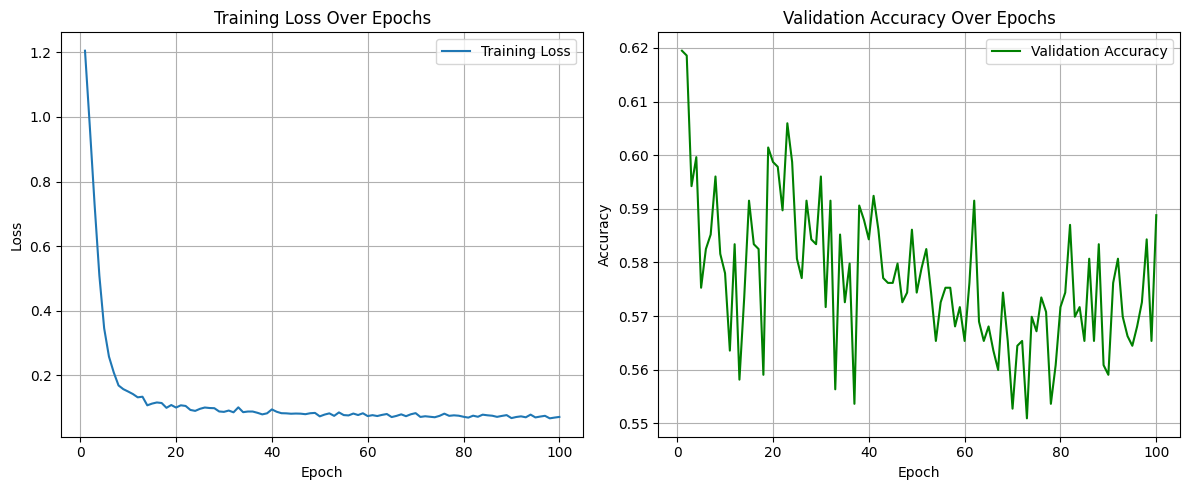

In [41]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()